In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
#HÜCRE 1

# =========================
# MASTER MANIFEST + MASTER SPLIT (TEK KAYNAK)  ✅ FIXED
# =========================
import os, re, glob, json
import pandas as pd
import numpy as np

CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
label2id = {c:i for i,c in enumerate(CLASS_LABELS)}

# ✅ VISUAL inference sabitleri (VAL/TEST/PROD aynı)
VIS_CONF_TH = 0.5
VIS_SAMPLE_EVERY_N_FRAMES = 2
VIS_MAX_SAMPLES = 30  # senin raporda kullandığın değer neyse onu yaz (ör: 30)

CREMA_VIDEO_ROOT = "/content/drive/MyDrive/crema_d_video"
SPLIT_ROOT = "/content/drive/MyDrive/crema_master_split"
os.makedirs(SPLIT_ROOT, exist_ok=True)

MASTER_MANIFEST_PATH = os.path.join(SPLIT_ROOT, "crema_video_manifest.csv")
SPLIT_INFO_PATH      = os.path.join(SPLIT_ROOT, "split_info.json")

EMO_MAP = {"ANG":"angry","DIS":"disgust","FEA":"fear","HAP":"happy","NEU":"neutral","SAD":"sad"}
FNAME_RE = re.compile(r"^(?P<actor>\d{4})_(?P<sent>[A-Z]{3})_(?P<emo>[A-Z]{3})_(?P<int>[A-Z]{2})\.(?P<ext>\w+)$")
VIDEO_EXTS = (".flv",".mp4",".avi",".mov",".mkv")

# 1) MASTER manifest üret
video_files = []
for ext in VIDEO_EXTS:
    video_files.extend(glob.glob(os.path.join(CREMA_VIDEO_ROOT, f"**/*{ext}"), recursive=True))
video_files = sorted(video_files)

rows, bad = [], 0
for p in video_files:
    fname = os.path.basename(p)
    m = FNAME_RE.match(fname)
    if not m:
        bad += 1
        continue

    emo_c = m.group("emo")
    if emo_c not in EMO_MAP:
        bad += 1
        continue

    emo = EMO_MAP[emo_c]
    rows.append({
        "actor_id": int(m.group("actor")),          # ✅ py int
        "sentence": m.group("sent"),
        "emotion": emo,
        "label": int(label2id[emo]),               # ✅ py int
        "video_path": p,
        "filename": fname,
    })

df_manifest = pd.DataFrame(rows)
print("MASTER manifest parsed:", len(df_manifest), " | unparsed:", bad)
df_manifest.to_csv(MASTER_MANIFEST_PATH, index=False)
print("✅ Saved MASTER manifest:", MASTER_MANIFEST_PATH)

# 2) MASTER split üret (seed ile kilitli, actor-based)
SEED = 42

# ✅ numpy/pandas dtype yerine saf python list
actors = sorted(df_manifest["actor_id"].unique().tolist())  # <- list() önemli
rng = np.random.RandomState(SEED)

actors_shuffled = actors.copy()
rng.shuffle(actors_shuffled)

n = len(actors_shuffled)
n_train = int(0.75 * n)
n_val   = int(0.10 * n)

# ✅ JSON-safe: hepsini py int'e çevir
train_actors = sorted([int(x) for x in actors_shuffled[:n_train]])
val_actors   = sorted([int(x) for x in actors_shuffled[n_train:n_train+n_val]])
test_actors  = sorted([int(x) for x in actors_shuffled[n_train+n_val:]])

train_df = df_manifest[df_manifest["actor_id"].isin(train_actors)].reset_index(drop=True)
val_df   = df_manifest[df_manifest["actor_id"].isin(val_actors)].reset_index(drop=True)
test_df  = df_manifest[df_manifest["actor_id"].isin(test_actors)].reset_index(drop=True)

train_path = os.path.join(SPLIT_ROOT, "train_manifest.csv")
val_path   = os.path.join(SPLIT_ROOT, "val_manifest.csv")
test_path  = os.path.join(SPLIT_ROOT, "test_manifest.csv")

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

split_info = {
    "seed": int(SEED),
    "n_actors": int(n),
    "train_actors": train_actors,
    "val_actors": val_actors,
    "test_actors": test_actors,
    "paths": {
        "train": train_path,
        "val": val_path,
        "test": test_path,
        "master_manifest": MASTER_MANIFEST_PATH
    }
}

if os.path.exists(SPLIT_INFO_PATH):
    os.remove(SPLIT_INFO_PATH)

with open(SPLIT_INFO_PATH, "w", encoding="utf-8") as f:
    json.dump(split_info, f, indent=2)

print("✅ Saved MASTER split:", SPLIT_ROOT)
print("Train/Val/Test clips:", len(train_df), len(val_df), len(test_df))
print("VIS params:", {"conf_th": VIS_CONF_TH, "sample_every_n_frames": VIS_SAMPLE_EVERY_N_FRAMES, "max_samples": VIS_MAX_SAMPLES})


MASTER manifest parsed: 7439  | unparsed: 0
✅ Saved MASTER manifest: /content/drive/MyDrive/crema_master_split/crema_video_manifest.csv
✅ Saved MASTER split: /content/drive/MyDrive/crema_master_split
Train/Val/Test clips: 5557 738 1144
VIS params: {'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}


In [ ]:
#HÜCRE 2
from google.colab import drive
drive.mount('/content/drive')

import os, re, glob, json, fnmatch, subprocess, shutil, random, math
import numpy as np
import pandas as pd

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    try:
        import tensorflow as tf
        tf.random.set_seed(seed)
    except Exception:
        pass

SEED = 42
seed_everything(SEED)
print("Seed:", SEED)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Seed: 42


In [ ]:
#HÜCRE 3
CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
label2id = {c:i for i,c in enumerate(CLASS_LABELS)}
id2label = {i:c for c,i in label2id.items()}

CREMA_VIDEO_ROOT = "/content/drive/MyDrive/crema_d_video"
SPLIT_ROOT = "/content/drive/MyDrive/crema_master_split"

TRAIN_MANIFEST = os.path.join(SPLIT_ROOT, "train_manifest.csv")
VAL_MANIFEST   = os.path.join(SPLIT_ROOT, "val_manifest.csv")
TEST_MANIFEST  = os.path.join(SPLIT_ROOT, "test_manifest.csv")
SPLIT_INFO     = os.path.join(SPLIT_ROOT, "split_info.json")

assert os.path.exists(TRAIN_MANIFEST), "train_manifest.csv yok!"
assert os.path.exists(VAL_MANIFEST),   "val_manifest.csv yok!"
assert os.path.exists(TEST_MANIFEST),  "test_manifest.csv yok!"
print("✅ Master split bulundu:", SPLIT_ROOT)


✅ Master split bulundu: /content/drive/MyDrive/crema_master_split


In [ ]:
#HÜCRE 4
train_df = pd.read_csv(TRAIN_MANIFEST)
val_df   = pd.read_csv(VAL_MANIFEST)
test_df  = pd.read_csv(TEST_MANIFEST)

print("Train:", len(train_df), " Val:", len(val_df), " Test:", len(test_df))
print("Unique actors | Train/Val/Test:",
      train_df["actor_id"].nunique(),
      val_df["actor_id"].nunique(),
      test_df["actor_id"].nunique())

display(test_df.head())


Train: 5557  Val: 738  Test: 1144
Unique actors | Train/Val/Test: 68 9 14


actor_id sentence  emotion  label  \
0      1002      DFA    angry      0   
1      1002      DFA  disgust      1   
2      1002      DFA     fear      2   
3      1002      DFA    happy      3   
4      1002      DFA  neutral      4   

                                          video_path             filename  
0  /content/drive/MyDrive/crema_d_video/1002_DFA_...  1002_DFA_ANG_XX.flv  
1  /content/drive/MyDrive/crema_d_video/1002_DFA_...  1002_DFA_DIS_XX.flv  
2  /content/drive/MyDrive/crema_d_video/1002_DFA_...  1002_DFA_FEA_XX.flv  
3  /content/drive/MyDrive/crema_d_video/1002_DFA_...  1002_DFA_HAP_XX.flv  
4  /content/drive/MyDrive/crema_d_video/1002_DFA_...  1002_DFA_NEU_XX.flv

In [ ]:
#HÜCRE 5
train_actors = set(train_df["actor_id"].astype(int).tolist())
val_actors   = set(val_df["actor_id"].astype(int).tolist())
test_actors  = set(test_df["actor_id"].astype(int).tolist())

print("Leak train∩test:", len(train_actors & test_actors))
print("Leak train∩val :", len(train_actors & val_actors))
print("Leak val∩test  :", len(val_actors & test_actors))

assert len(train_actors & test_actors) == 0, "❌ Train-Test actor leakage!"
assert len(train_actors & val_actors) == 0,  "❌ Train-Val actor leakage!"
assert len(val_actors & test_actors) == 0,   "❌ Val-Test actor leakage!"
print("✅ Actor-based split temiz.")


Leak train∩test: 0
Leak train∩val : 0
Leak val∩test  : 0
✅ Actor-based split temiz.


AUDIO (Wav2Vec2) — aynı test_df üzerinde evaluation

In [ ]:
#HÜCRE 6
AUDIO_OUT_ROOT = "/content/drive/MyDrive/crema_audio_eval_master"
CACHE_DIR      = os.path.join(AUDIO_OUT_ROOT, "cache_audio")
AUDIO_REPORTS  = os.path.join(AUDIO_OUT_ROOT, "reports")

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(AUDIO_REPORTS, exist_ok=True)

TARGET_SR = 16000

def video_to_wav(video_path, out_wav_path, sr=16000):
    os.makedirs(os.path.dirname(out_wav_path), exist_ok=True)
    cmd = [
        "ffmpeg", "-y",
        "-i", video_path,
        "-vn",
        "-acodec", "pcm_s16le",
        "-ar", str(sr),
        "-ac", "1",
        out_wav_path
    ]
    r = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return r.returncode == 0

def ensure_audio_cached(row, sr=16000):
    base = os.path.splitext(row["filename"])[0] + ".wav"
    out_wav = os.path.join(CACHE_DIR, base)
    if os.path.exists(out_wav) and os.path.getsize(out_wav) > 0:
        return out_wav
    ok = video_to_wav(row["video_path"], out_wav, sr=sr)
    return out_wav if ok else None

# quick sanity
sample = test_df.iloc[0].to_dict()
wp = ensure_audio_cached(sample, sr=TARGET_SR)
print("Sample wav:", wp, "| exists:", os.path.exists(wp))


Sample wav: /content/drive/MyDrive/crema_audio_eval_master/cache_audio/1002_DFA_ANG_XX.wav | exists: True


In [ ]:
#HÜCRE 7
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro")
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_LABELS))))
    rep = classification_report(y_true, y_pred, target_names=CLASS_LABELS, zero_division=0)
    return acc, mf1, cm, rep

class AudioFromVideoDataset(Dataset):
    def __init__(self, df, max_sec=3.5, sr=16000):
        self.df = df.reset_index(drop=True)
        self.max_len = int(sr * max_sec)
        self.sr = sr

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx].to_dict()
        wav_path = ensure_audio_cached(row, sr=self.sr)
        y = int(row["label"])

        if wav_path is None or (not os.path.exists(wav_path)):
            audio = np.zeros(self.max_len, dtype=np.float32)
        else:
            audio, _ = librosa.load(wav_path, sr=self.sr)
            if len(audio) > self.max_len: audio = audio[:self.max_len]
            else: audio = np.pad(audio, (0, self.max_len - len(audio)))
            audio = audio.astype(np.float32)

        return audio, y

def collate_wav2vec(batch):
    audios, labels = zip(*batch)
    inputs = processor(
        list(audios),
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True
    )
    y = torch.tensor(labels, dtype=torch.long)
    return inputs.input_values, inputs.attention_mask, y


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
#HÜCRE 8
AUDIO_CKPT = "/content/drive/MyDrive/experiment_results/best_wav2vec2_speaker_indep.pt"
assert os.path.exists(AUDIO_CKPT), "❌ Audio ckpt bulunamadı!"

@torch.no_grad()
def eval_wav2vec2_on_master_test(ckpt_path, df_test, default_max_sec=3.5, bs=8):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = {}
    if isinstance(ckpt, dict):
        cfg = ckpt.get("cfg", {}) or ckpt.get("config", {}) or {}

    max_sec = float(cfg.get("max_sec", default_max_sec))

    ds = AudioFromVideoDataset(df_test, max_sec=max_sec, sr=TARGET_SR)
    dl = DataLoader(ds, batch_size=bs, shuffle=False, collate_fn=collate_wav2vec)

    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base-960h",
        num_labels=len(CLASS_LABELS)
    ).to(DEVICE)

    state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
    model.load_state_dict(state, strict=False)
    model.eval()

    y_true, y_pred = [], []
    for x, am, y in dl:
        x, am = x.to(DEVICE), am.to(DEVICE)
        logits = model(input_values=x, attention_mask=am).logits
        y_pred += logits.argmax(dim=-1).cpu().tolist()
        y_true += y.tolist()

    acc, mf1, cm, rep = compute_metrics(y_true, y_pred)
    return acc, mf1, cm, rep, cfg

audio_acc, audio_mf1, audio_cm, audio_rep, audio_cfg = eval_wav2vec2_on_master_test(AUDIO_CKPT, test_df)
print("🎧 AUDIO on MASTER test_df")
print("Acc:", audio_acc, "MacroF1:", audio_mf1)
print(audio_rep)


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🎧 AUDIO on MASTER test_df
Acc: 0.7959895379250218 MacroF1: 0.797305644429415
              precision    recall  f1-score   support

       angry       0.91      0.94      0.93       196
     disgust       0.85      0.74      0.79       196
        fear       0.72      0.67      0.69       196
       happy       0.89      0.77      0.82       196
     neutral       0.79      0.92      0.85       167
         sad       0.65      0.75      0.70       196

    accuracy                           0.80      1147
   macro avg       0.80      0.80      0.80      1147
weighted avg       0.80      0.80      0.80      1147



In [ ]:
#HÜCRE 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion(cm, class_names, title="Confusion Matrix"):
    if cm is None:
        print("⚠️ Confusion matrix boş (None).")
        return

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_confusion_normalized(cm, class_names, title="Confusion Matrix (Normalized)"):
    if cm is None:
        print("⚠️ Confusion matrix boş (None).")
        return

    cm = cm.astype(np.float32)
    cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Greens",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


=== AUDIO ACTOR-BASED ===


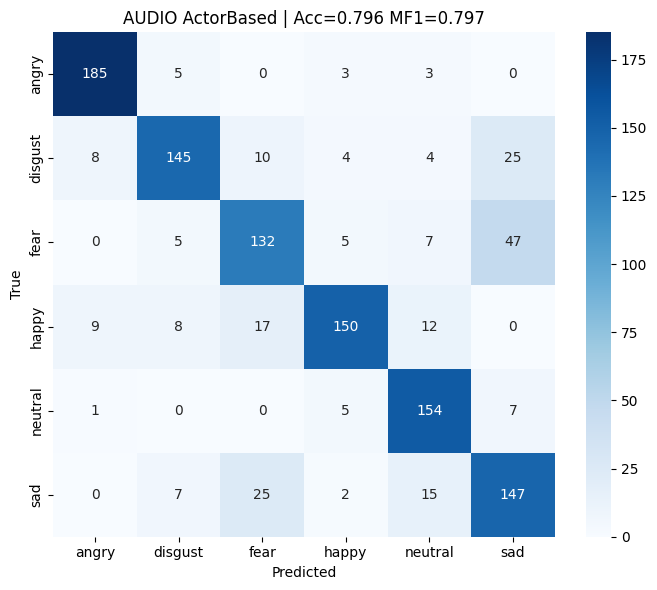

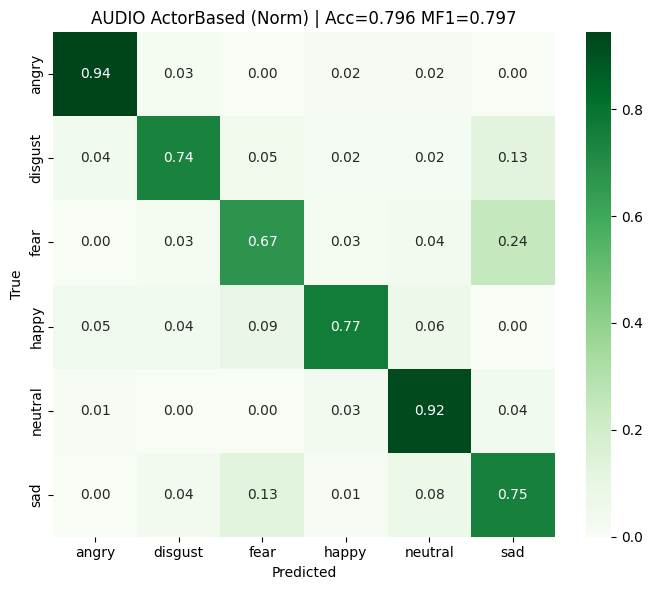

In [ ]:
#HÜCRE 9
print("=== AUDIO ACTOR-BASED ===")
plot_confusion(audio_cm, CLASS_LABELS,
               title=f"AUDIO ActorBased | Acc={audio_acc:.3f} MF1={audio_mf1:.3f}")
plot_confusion_normalized(audio_cm, CLASS_LABELS,
                          title=f"AUDIO ActorBased (Norm) | Acc={audio_acc:.3f} MF1={audio_mf1:.3f}")


 AUDIO — RANDOM SPLIT MODEL

In [ ]:
#HÜCRE 10
import os

AUDIO_RANDOM_CKPT = "/content/drive/MyDrive/best_wav2vec2_exp2.pt"  # ✅ mavi dosya
print("Random ckpt:", AUDIO_RANDOM_CKPT)
print("Exists:", os.path.exists(AUDIO_RANDOM_CKPT))

if not os.path.exists(AUDIO_RANDOM_CKPT):
    raise FileNotFoundError("❌ Dosya bulunamadı. Drive içinde başka klasördeyse yolunu düzelt.")


Random ckpt: /content/drive/MyDrive/best_wav2vec2_exp2.pt
Exists: True


In [ ]:
#HÜCRE 11
import torch

ckpt = torch.load(AUDIO_RANDOM_CKPT, map_location="cpu")
print("Type:", type(ckpt))

if isinstance(ckpt, dict):
    print("Top-level keys:", list(ckpt.keys())[:30])
    cfg = ckpt.get("cfg", {}) or ckpt.get("config", {}) or {}
    print("Config keys sample:", list(cfg.keys())[:20] if isinstance(cfg, dict) else type(cfg))
    if "model" in ckpt and isinstance(ckpt["model"], dict):
        print("State dict sample:", list(ckpt["model"].keys())[:15])
else:
    print("Raw state_dict sample:", list(ckpt.keys())[:15])


Type: <class 'dict'>
Top-level keys: ['model', 'val_acc']
Config keys sample: []
State dict sample: ['wav2vec2.masked_spec_embed', 'wav2vec2.feature_extractor.conv_layers.0.conv.weight', 'wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight', 'wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias', 'wav2vec2.feature_extractor.conv_layers.1.conv.weight', 'wav2vec2.feature_extractor.conv_layers.2.conv.weight', 'wav2vec2.feature_extractor.conv_layers.3.conv.weight', 'wav2vec2.feature_extractor.conv_layers.4.conv.weight', 'wav2vec2.feature_extractor.conv_layers.5.conv.weight', 'wav2vec2.feature_extractor.conv_layers.6.conv.weight', 'wav2vec2.feature_projection.layer_norm.weight', 'wav2vec2.feature_projection.layer_norm.bias', 'wav2vec2.feature_projection.projection.weight', 'wav2vec2.feature_projection.projection.bias', 'wav2vec2.encoder.pos_conv_embed.conv.bias']


In [ ]:
#HÜCRE 12
audio_rand_acc, audio_rand_mf1, audio_rand_cm, audio_rand_rep, audio_rand_cfg = \
    eval_wav2vec2_on_master_test(
        AUDIO_RANDOM_CKPT,
        test_df
    )

print("\n🎧 AUDIO (RANDOM TRAIN CKPT) → MASTER test_df")
print("CKPT:", AUDIO_RANDOM_CKPT)
print("Acc:", audio_rand_acc, "MacroF1:", audio_rand_mf1)

if isinstance(audio_rand_cfg, dict) and len(audio_rand_cfg) > 0:
    show_keys = ["max_sec","batch_size","lr_head","lr_backbone","weight_decay","unfreeze_epoch","specaugment"]
    print("Config subset:", {k: audio_rand_cfg.get(k) for k in show_keys if k in audio_rand_cfg})

print(audio_rand_rep)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🎧 AUDIO (RANDOM TRAIN CKPT) → MASTER test_df
CKPT: /content/drive/MyDrive/best_wav2vec2_exp2.pt
Acc: 0.949433304272014 MacroF1: 0.9496228932233182
              precision    recall  f1-score   support

       angry       0.98      0.97      0.98       196
     disgust       0.94      0.96      0.95       196
        fear       0.92      0.93      0.93       196
       happy       0.97      0.96      0.97       196
     neutral       0.95      0.96      0.96       167
         sad       0.93      0.90      0.91       196

    accuracy                           0.95      1147
   macro avg       0.95      0.95      0.95      1147
weighted avg       0.95      0.95      0.95      1147



=== AUDIO RANDOM-SPLIT TRAIN (eval on MASTER test_df) ===


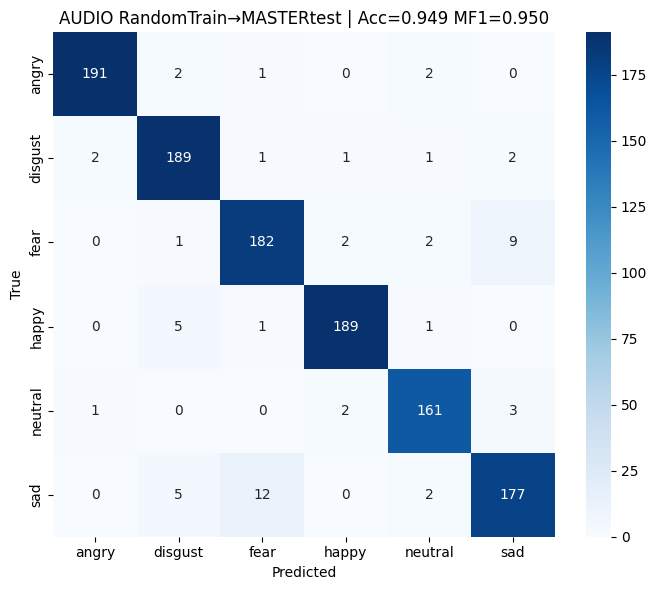

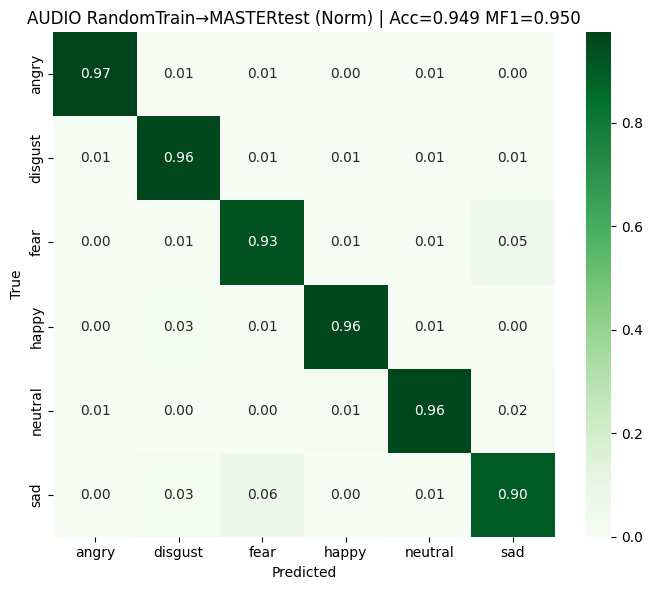

In [ ]:
#HÜCRE 13
print("=== AUDIO RANDOM-SPLIT TRAIN (eval on MASTER test_df) ===")
plot_confusion(audio_rand_cm, CLASS_LABELS,
               title=f"AUDIO RandomTrain→MASTERtest | Acc={audio_rand_acc:.3f} MF1={audio_rand_mf1:.3f}")
plot_confusion_normalized(audio_rand_cm, CLASS_LABELS,
                          title=f"AUDIO RandomTrain→MASTERtest (Norm) | Acc={audio_rand_acc:.3f} MF1={audio_rand_mf1:.3f}")


VISUAL (best_final_model.keras) — aynı test_df üzerinde evaluation

In [ ]:
#HÜCRE 15
import os
import cv2
import urllib.request

# --- SSD Face Detector (OpenCV DNN) ---
detector_dir = "/content/face_detector_model"
os.makedirs(detector_dir, exist_ok=True)

prototxt_path   = os.path.join(detector_dir, "deploy.prototxt.txt")
caffemodel_path = os.path.join(detector_dir, "res10_300x300_ssd_iter_140000.caffemodel")

if (not os.path.exists(prototxt_path)) or (not os.path.exists(caffemodel_path)):
    print("⚠️ Face detector dosyaları eksik, indiriliyor...")

    url_proto = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
    url_model = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"

    urllib.request.urlretrieve(url_proto, prototxt_path)
    urllib.request.urlretrieve(url_model, caffemodel_path)

    print("✅ Face detector dosyaları indirildi.")

print("🔄 Face detector yükleniyor...")
face_net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
print("✅ face_net hazır.")

# ❌ preprocess_face ve _best_face_roi BURADA OLMAYACAK.
# Onlar tek kaynak olarak HÜCRE 18'de kalacak.


⚠️ Face detector dosyaları eksik, indiriliyor...
✅ Face detector dosyaları indirildi.
🔄 Face detector yükleniyor...
✅ face_net hazır.


In [ ]:
#HÜCRE 18
# =========================
# VISUAL SETUP (Keras + preprocess + ROI) ✅  (eski notebook'a sadık)
# NOTE: face_net HÜCRE 15'te hazırlanıyor.
# =========================
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# 0) Visual model path
VISUAL_MODEL_PATH = "/content/drive/MyDrive/best_final_model.keras"
assert os.path.exists(VISUAL_MODEL_PATH), f"❌ Visual model yok: {VISUAL_MODEL_PATH}"

# ✅ face_net sanity (HÜCRE 15 çalıştı mı?)
assert "face_net" in globals(), "❌ face_net bulunamadı. Önce HÜCRE 15'i çalıştır!"

print("OpenCV:", cv2.__version__)
print("VIS params:", {"conf_th": VIS_CONF_TH, "sample_every_n_frames": VIS_SAMPLE_EVERY_N_FRAMES, "max_samples": VIS_MAX_SAMPLES})
print("LABEL_ORDER:", CLASS_LABELS)

# 1) Eski notebook preprocess (BGR->RGB + resize + /255)
def preprocess_face(face_img, target_size=(224, 224)):
    if face_img is None or face_img.size == 0:
        return None
    img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
    img_normalized = img_resized.astype("float32") / 255.0
    return np.expand_dims(img_normalized, axis=0)  # (1,224,224,3)

# 2) SSD ile kareden en iyi yüz ROI (max confidence)
def _best_face_roi(frame, conf_th=VIS_CONF_TH, min_size=20):
    if frame is None:
        return None

    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(
        cv2.resize(frame, (300, 300)),
        1.0,
        (300, 300),
        (104.0, 177.0, 123.0)
    )
    face_net.setInput(blob)
    detections = face_net.forward()

    best = None  # (conf, sx, sy, ex, ey)
    for i in range(detections.shape[2]):
        conf = float(detections[0, 0, i, 2])
        if conf < conf_th:
            continue

        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (sx, sy, ex, ey) = box.astype("int")

        sx, sy = max(0, sx), max(0, sy)
        ex, ey = min(w, ex), min(h, ey)

        if (ex - sx) < min_size or (ey - sy) < min_size:
            continue

        if (best is None) or (conf > best[0]):
            best = (conf, sx, sy, ex, ey)

    if best is None:
        return None

    _, sx, sy, ex, ey = best
    roi = frame[sy:ey, sx:ex]
    if roi is None or roi.size == 0:
        return None
    return roi

# 3) Keras visual model load
emotion_model = load_model(VISUAL_MODEL_PATH)
print("✅ Visual model loaded.")
print("Input shape:", emotion_model.input_shape)


OpenCV: 4.12.0
VIS params: {'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
LABEL_ORDER: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
✅ Visual model loaded.
Input shape: (None, 224, 224, 3)


In [ ]:
# =========================
# HÜCRE 16 (GÜNCEL) ✅
# Visual predict + eval on MASTER test_df
# =========================
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import cv2

def predict_video_label(
    video_path,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, {"reason": "cannot_open"}

    preds = []
    frame_idx = 0
    taken = 0
    noface = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        if sample_every_n_frames > 1 and (frame_idx % sample_every_n_frames != 0):
            continue

        face_roi = _best_face_roi(frame, conf_th=conf_th)
        if face_roi is None:
            noface += 1
            continue

        x = preprocess_face(face_roi, (224, 224))
        if x is None:
            noface += 1
            continue

        p = emotion_model.predict(x, verbose=0)[0]  # (6,)
        preds.append(int(np.argmax(p)))

        taken += 1
        if taken >= max_samples:
            break

    cap.release()

    if len(preds) == 0:
        return None, {"reason": "no_face", "noface_frames": int(noface)}

    pred = int(np.bincount(preds, minlength=len(CLASS_LABELS)).argmax())
    meta = {
        "frames_used": int(taken),
        "noface_frames": int(noface),
        "conf_th": float(conf_th),
        "sample_every_n_frames": int(sample_every_n_frames),
        "max_samples": int(max_samples),
    }
    return pred, meta


def _extract_true_label(row):
    """
    Robust GT label extraction:
    - label_id / y / label (int) -> directly
    - emotion / emo (string) -> map with label2id
    Returns int in [0..C-1] or -1
    """
    # 1) direct numeric fields (preferred)
    for k in ["label_id", "y", "label"]:
        if k in row:
            v = row[k]
            try:
                # pandas may store as numpy types; still fine
                if v is not None and str(v) != "nan":
                    return int(v)
            except Exception:
                pass

    # 2) string emotion fields
    for k in ["emotion", "emo"]:
        if k in row:
            v = row[k]
            if isinstance(v, str) and len(v) > 0:
                return int(label2id.get(v, -1))
            # bazen pandas object -> np.str_ vs
            try:
                sv = str(v)
                if sv != "nan":
                    return int(label2id.get(sv, -1))
            except Exception:
                pass

    return -1


def eval_visual_on_master_test(
    df,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES,
    limit=None
):
    """
    limit=None => tüm df, yoksa ilk limit örnek
    """
    y_true, y_pred = [], []
    fail_open, fail_noface = 0, 0
    skip_no_path, skip_bad_label = 0, 0

    it_df = df if limit is None else df.head(int(limit))

    for _, row in it_df.iterrows():
        # video_path robust find
        video_path = None
        for k in ["video_path", "path", "video", "video_file", "filepath"]:
            if k in row and isinstance(row[k], str) and len(row[k]) > 0:
                video_path = row[k]
                break

        if video_path is None:
            skip_no_path += 1
            continue

        # true label
        true = _extract_true_label(row)
        if true < 0 or true >= len(CLASS_LABELS):
            skip_bad_label += 1
            continue

        pred, meta = predict_video_label(
            video_path,
            conf_th=conf_th,
            sample_every_n_frames=sample_every_n_frames,
            max_samples=max_samples
        )

        if pred is None:
            if meta.get("reason") == "cannot_open":
                fail_open += 1
            else:
                fail_noface += 1
            continue

        y_true.append(true)
        y_pred.append(pred)

    acc = accuracy_score(y_true, y_pred) if y_true else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if y_true else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_LABELS)))) if y_true else None
    rep = classification_report(y_true, y_pred, target_names=CLASS_LABELS, zero_division=0) if y_true else ""

    meta_out = {
        "used": int(len(y_true)),
        "total_target": int(len(it_df)),
        "fail_open": int(fail_open),
        "fail_noface": int(fail_noface),
        "skip_no_path": int(skip_no_path),
        "skip_bad_label": int(skip_bad_label),
        "conf_th": float(conf_th),
        "sample_every_n_frames": int(sample_every_n_frames),
        "max_samples": int(max_samples),
        "limit": None if limit is None else int(limit)
    }

    print("🎥 VISUAL eval (SSD + eski preprocess)")
    print(
        f"Used: {meta_out['used']} / {meta_out['total_target']} | "
        f"fail_open: {meta_out['fail_open']} | fail_noface: {meta_out['fail_noface']} | "
        f"skip_no_path: {meta_out['skip_no_path']} | skip_bad_label: {meta_out['skip_bad_label']}"
    )
    print(f"Acc: {acc:.4f} | Macro-F1: {mf1:.4f}")

    return acc, mf1, cm, rep, meta_out


In [ ]:
#HÜCRE 17
import numpy as np
import cv2

def predict_visual_proba(
    video_path,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES
):
    """
    Returns:
      proba: np.ndarray shape (6,) or None
      meta : dict
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None, {"reason": "cannot_open"}

    probs = []
    frame_idx = 0
    taken = 0
    noface = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        if sample_every_n_frames > 1 and (frame_idx % sample_every_n_frames != 0):
            continue

        face_roi = _best_face_roi(frame, conf_th=conf_th)
        if face_roi is None:
            noface += 1
            continue

        x = preprocess_face(face_roi, (224, 224))
        if x is None:
            noface += 1
            continue

        p = emotion_model.predict(x, verbose=0)[0].astype("float32")  # (6,)
        probs.append(p)

        taken += 1
        if taken >= max_samples:
            break

    cap.release()

    if len(probs) == 0:
        return None, {"reason": "no_face", "noface_frames": int(noface)}

    probs = np.stack(probs, axis=0)          # (T,6)
    proba = probs.mean(axis=0)               # (6,)
    proba = proba / (proba.sum() + 1e-9)     # güvenlik normalize

    meta = {
        "frames_used": int(taken),
        "noface_frames": int(noface),
        "conf_th": float(conf_th),
        "sample_every_n_frames": int(sample_every_n_frames),
        "max_samples": int(max_samples),
    }
    return proba, meta


In [ ]:
#HÜCRE 19
visual_acc, visual_mf1, visual_cm, visual_rep, visual_meta = eval_visual_on_master_test(
    test_df,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES,
    limit=None
)


🎥 VISUAL eval (SSD + eski preprocess)
Used: 1147 / 1147 | fail_open: 0 | fail_noface: 0 | skip_no_path: 0 | skip_bad_label: 0
Acc: 0.4045 | Macro-F1: 0.3703


=== VISUAL (best_final_model.keras) ===


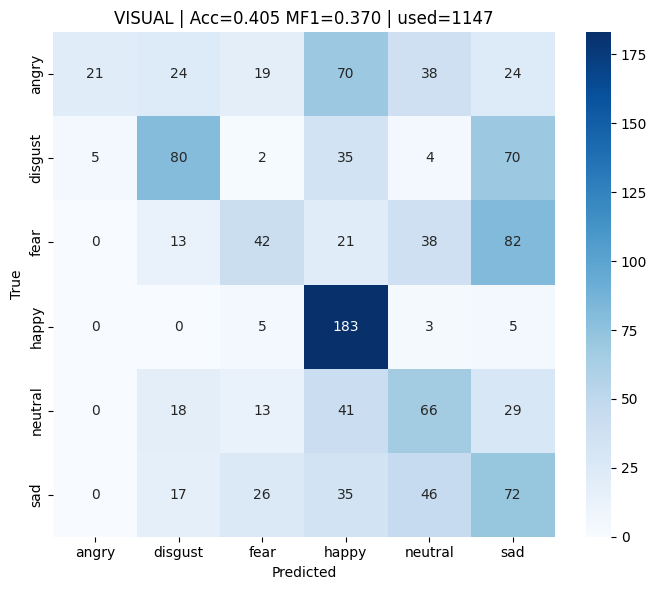

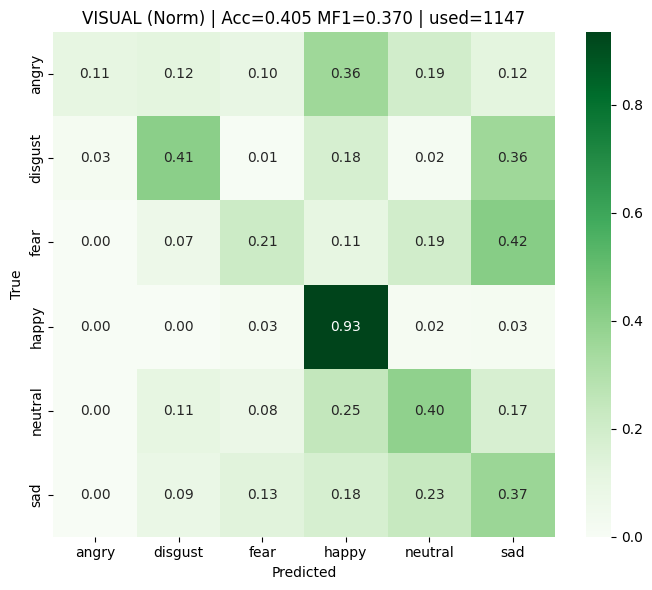

In [ ]:
#HÜCRE 21
print("=== VISUAL (best_final_model.keras) ===")
plot_confusion(visual_cm, CLASS_LABELS,
               title=f"VISUAL | Acc={visual_acc:.3f} MF1={visual_mf1:.3f} | used={visual_meta['used']}")
plot_confusion_normalized(visual_cm, CLASS_LABELS,
                          title=f"VISUAL (Norm) | Acc={visual_acc:.3f} MF1={visual_mf1:.3f} | used={visual_meta['used']}")


In [ ]:
#HÜCRE 22
import pandas as pd

summary = pd.DataFrame([
    {"model": "Audio ActorBased", "acc": audio_acc, "macro_f1": audio_mf1},
    {"model": "Audio RandomTrain→MASTERtest", "acc": audio_rand_acc, "macro_f1": audio_rand_mf1},
    {"model": f"Visual (used={visual_meta['used']})", "acc": visual_acc, "macro_f1": visual_mf1},
])

summary = summary.sort_values("macro_f1", ascending=False).reset_index(drop=True)
summary


model       acc  macro_f1
0  Audio RandomTrain→MASTERtest  0.949433  0.949623
1              Audio ActorBased  0.795990  0.797306
2            Visual (used=1147)  0.404534  0.370339

In [ ]:
#HÜCRE 23
def show_ckpt_labelmap(path):
    import torch, json
    ckpt = torch.load(path, map_location="cpu")
    if isinstance(ckpt, dict):
        for k in ["label2id","id2label","classes","class_labels","CLASS_LABELS"]:
            if k in ckpt:
                print("FOUND:", k, ckpt[k])
        cfg = ckpt.get("cfg", {}) or ckpt.get("config", {}) or {}
        if isinstance(cfg, dict):
            for k in ["label2id","id2label","classes","class_labels","CLASS_LABELS"]:
                if k in cfg:
                    print("FOUND in cfg:", k, cfg[k])
    else:
        print("ckpt is raw state_dict; no metadata.")

show_ckpt_labelmap(AUDIO_CKPT)
show_ckpt_labelmap(AUDIO_RANDOM_CKPT)


In [ ]:
# =========================
# HÜCRE 24 (GÜNCEL) ✅
# 10 örnek sanity check — VIS paramlarıyla aynı
# =========================
import numpy as np

# test_df içinden 10 örnek al
sample_rows = test_df.sample(10, random_state=42)

for _, row in sample_rows.iterrows():
    pv, meta = predict_visual_proba(
        row["video_path"],
        conf_th=VIS_CONF_TH,
        sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
        max_samples=VIS_MAX_SAMPLES
    )
    if pv is None:
        print("SKIP (no face):", row.get("filename", "unknown"))
        continue

    pred_idx = int(np.argmax(pv))
    pred_name = CLASS_LABELS[pred_idx]

    # GT label (robust)
    gt = row.get("emotion", None)
    if gt is None or str(gt) == "nan":
        # fallback: numeric label -> name
        try:
            gt_id = int(row.get("label", -1))
            gt = CLASS_LABELS[gt_id] if 0 <= gt_id < len(CLASS_LABELS) else "unknown"
        except Exception:
            gt = "unknown"

    print(row.get("filename", "unknown"), "| GT:", gt, "| Pred:", pred_name, "| meta:", meta)


1021_IWL_SAD_XX.flv | GT: sad | Pred: neutral | meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
1085_IWW_DIS_XX.flv | GT: disgust | Pred: neutral | meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
1072_ITH_SAD_XX.flv | GT: sad | Pred: neutral | meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
1024_DFA_NEU_XX.flv | GT: neutral | Pred: neutral | meta: {'frames_used': 27, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
1085_TSI_HAP_XX.flv | GT: happy | Pred: happy | meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
1003_IOM_NEU_XX.flv | GT: neutral | Pred: happy | meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
1072_IEO_DIS_MD.flv | GT: disgust | Pred: neutra

PROBA ÇIKARMA

In [ ]:
#HÜCRE 25
import numpy as np

_visual_proba_cache = {}  # video_path -> (proba or None)

def get_visual_proba_cached(
    video_path,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES
):
    if video_path in _visual_proba_cache:
        return _visual_proba_cache[video_path]

    pv, _meta = predict_visual_proba(
        video_path,
        conf_th=conf_th,
        sample_every_n_frames=sample_every_n_frames,
        max_samples=max_samples
    )
    _visual_proba_cache[video_path] = pv  # np.array(6,) OR None
    return pv

print("✅ Visual proba cache ready.")


✅ Visual proba cache ready.


In [ ]:
#HÜCRE 26
@torch.no_grad()
def predict_audio_proba_ckpt(
    ckpt_path,
    df,
    default_max_sec=3.5,
    bs=8
):
    """
    Returns:
      acc, macro_f1, cm, report, cfg,
      probs: np.ndarray [N, C],
      y_true: np.ndarray [N]
    """

    ckpt = torch.load(ckpt_path, map_location="cpu")
    cfg = {}
    if isinstance(ckpt, dict):
        cfg = ckpt.get("cfg", {}) or ckpt.get("config", {}) or {}

    max_sec = float(cfg.get("max_sec", default_max_sec))

    ds = AudioFromVideoDataset(df, max_sec=max_sec, sr=TARGET_SR)
    dl = DataLoader(ds, batch_size=bs, shuffle=False, collate_fn=collate_wav2vec)

    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base-960h",
        num_labels=len(CLASS_LABELS)
    ).to(DEVICE)

    state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
    model.load_state_dict(state, strict=False)
    model.eval()

    y_true = []
    y_pred = []
    probs  = []

    for x, am, y in dl:
        x, am = x.to(DEVICE), am.to(DEVICE)
        logits = model(input_values=x, attention_mask=am).logits
        p = torch.softmax(logits, dim=-1)

        probs.append(p.cpu().numpy())
        y_pred += p.argmax(dim=-1).cpu().tolist()
        y_true += y.tolist()

    probs = np.concatenate(probs, axis=0)
    y_true = np.array(y_true)

    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro")
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASS_LABELS))))
    rep = classification_report(y_true, y_pred, target_names=CLASS_LABELS, zero_division=0)

    return acc, mf1, cm, rep, cfg, probs, y_true


In [ ]:
#HÜCRE 27
# AUDIO actor-based
val_audio_acc, val_audio_mf1, val_audio_cm, val_audio_rep, val_audio_cfg, val_audio_probs, val_audio_y = \
    predict_audio_proba_ckpt(AUDIO_CKPT, val_df)

# AUDIO random-train
val_audio_rand_acc, val_audio_rand_mf1, val_audio_rand_cm, val_audio_rand_rep, val_audio_rand_cfg, val_audio_rand_probs, val_audio_rand_y = \
    predict_audio_proba_ckpt(AUDIO_RANDOM_CKPT, val_df)

print("VAL audio actor-based:", val_audio_acc, val_audio_mf1)
print("VAL audio random-train:", val_audio_rand_acc, val_audio_rand_mf1)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VAL audio actor-based: 0.8143631436314364 0.8156722546906395
VAL audio random-train: 0.948509485094851 0.9484787137676616


In [ ]:
#HÜCRE 28
_visual_proba_cache = {}   # cache reset (param değişince eski sonuç dönmesin)


In [ ]:
#HÜCRE 29
from tqdm import tqdm
import numpy as np

def build_visual_probs_on_df(
    df,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES
):
    probs = []
    ok_mask = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        pv = get_visual_proba_cached(
            row["video_path"],
            conf_th=conf_th,
            sample_every_n_frames=sample_every_n_frames,
            max_samples=max_samples
        )
        if pv is None:
            ok_mask.append(False)
            probs.append(np.zeros(len(CLASS_LABELS), dtype=np.float32))  # placeholder
        else:
            ok_mask.append(True)
            probs.append(pv.astype(np.float32))
    return np.vstack(probs), np.array(ok_mask, dtype=bool)

# ✅ VAL öncesi cache reset (şart)
_visual_proba_cache = {}

val_visual_probs, val_vis_ok = build_visual_probs_on_df(
    val_df,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES
)
print("VAL visual ok:", val_vis_ok.sum(), "/", len(val_vis_ok), "noface:", (~val_vis_ok).sum())


100%|██████████| 738/738 [49:51<00:00,  4.05s/it]

VAL visual ok: 738 / 738 noface: 0


In [ ]:
#HÜCRE 30
print("Current CLASS_LABELS:", CLASS_LABELS)

# Audio ckpt metadata varsa yakala (bazı ckpt'lerde yoktur)
show_ckpt_labelmap(AUDIO_CKPT)
show_ckpt_labelmap(AUDIO_RANDOM_CKPT)

# Visual: model output shape check
print("Visual output units:", emotion_model.output_shape)


Current CLASS_LABELS: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
Visual output units: (None, 6)


In [ ]:
#HÜCRE 31
print("Audio probs shape:", val_audio_probs.shape, " y:", val_audio_y.shape)
print("Visual probs shape:", val_visual_probs.shape, " ok:", val_vis_ok.shape)
assert val_audio_probs.shape[0] == len(val_df) == val_visual_probs.shape[0] == val_audio_y.shape[0]


Audio probs shape: (738, 6)  y: (738,)
Visual probs shape: (738, 6)  ok: (738,)


In [ ]:
#HÜCRE 32
print("✅ VIS_PARAMS (VAL/TEST/PROD sabit):", {"conf_th": VIS_CONF_TH, "sample_every_n_frames": VIS_SAMPLE_EVERY_N_FRAMES, "max_samples": VIS_MAX_SAMPLES})
print("✅ LABEL_ORDER:", CLASS_LABELS)

from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def fuse_probs(p_audio, p_visual, w_audio):
    return w_audio * p_audio + (1.0 - w_audio) * p_visual

def grid_search_w(p_audio, p_visual, y_true, ok_mask, step=0.05):
    idx = np.where(ok_mask)[0]   # visual olmayanları drop
    A = p_audio[idx]
    V = p_visual[idx]
    y = y_true[idx]

    best = {"w": None, "mf1": -1.0, "acc": -1.0}
    rows = []

    for w in np.arange(0.0, 1.0 + 1e-9, step):
        P = fuse_probs(A, V, w)
        pred = P.argmax(axis=1)
        mf1 = f1_score(y, pred, average="macro")
        acc = accuracy_score(y, pred)
        rows.append((float(w), float(mf1), float(acc)))
        if mf1 > best["mf1"]:
            best = {"w": float(w), "mf1": float(mf1), "acc": float(acc)}

    return best, rows, idx

best_actor, rows_actor, idx_val = grid_search_w(val_audio_probs, val_visual_probs, val_audio_y, val_vis_ok, step=0.05)
best_rand,  rows_rand,  _       = grid_search_w(val_audio_rand_probs, val_visual_probs, val_audio_rand_y, val_vis_ok, step=0.05)

print("✅ BEST w (Audio ActorBased):", best_actor)
print("✅ BEST w (Audio RandomTrain):", best_rand)
print("VAL fusion uses:", len(idx_val), "/", len(val_df), " (visual ok)")


✅ VIS_PARAMS (VAL/TEST/PROD sabit): {'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
✅ LABEL_ORDER: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
✅ BEST w (Audio ActorBased): {'w': 0.55, 'mf1': 0.838517912610325, 'acc': 0.8373983739837398}
✅ BEST w (Audio RandomTrain): {'w': 0.75, 'mf1': 0.9484787137676616, 'acc': 0.948509485094851}
VAL fusion uses: 738 / 738  (visual ok)


In [ ]:
#HÜCRE 33
_visual_proba_cache = {}   # ✅ TEST cache reset

# 1) Audio probs on TEST (actor-based ckpt)
test_audio_acc, test_audio_mf1, test_audio_cm, test_audio_rep, test_audio_cfg, test_audio_probs, test_audio_y = \
    predict_audio_proba_ckpt(AUDIO_CKPT, test_df)

print("TEST audio:", test_audio_acc, test_audio_mf1)

# 2) Visual probs on TEST
test_visual_probs, test_vis_ok = build_visual_probs_on_df(
    test_df,
    conf_th=VIS_CONF_TH,
    sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
    max_samples=VIS_MAX_SAMPLES
)
print("TEST visual ok:", test_vis_ok.sum(), "/", len(test_vis_ok), "noface:", (~test_vis_ok).sum())

# 3) Sanity checks
assert test_audio_probs.shape[0] == test_visual_probs.shape[0] == len(test_df)
assert test_audio_probs.shape[1] == test_visual_probs.shape[1] == len(CLASS_LABELS)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TEST audio: 0.7959895379250218 0.797305644429415


100%|██████████| 1147/1147 [1:02:43<00:00,  3.28s/it]

TEST visual ok: 1147 / 1147 noface: 0


Using W_FINAL from VAL grid search: 0.55
✅ LATE FUSION (TEST) | w= 0.55
Acc: 0.7968613775065388 MacroF1: 0.7977511349236437
              precision    recall  f1-score   support

       angry       0.95      0.93      0.94       196
     disgust       0.88      0.69      0.77       196
        fear       0.78      0.62      0.69       196
       happy       0.85      0.91      0.88       196
     neutral       0.79      0.91      0.84       167
         sad       0.60      0.73      0.66       196

    accuracy                           0.80      1147
   macro avg       0.81      0.80      0.80      1147
weighted avg       0.81      0.80      0.80      1147



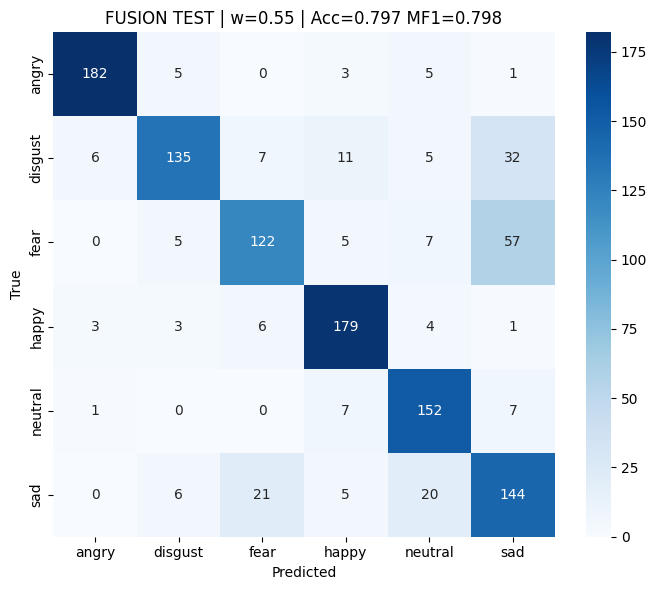

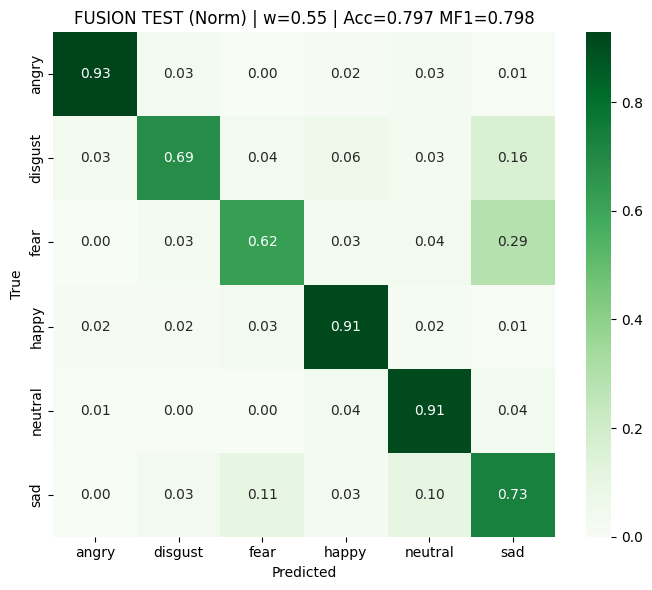

In [ ]:
#HÜCRE 34
W_FINAL = best_actor["w"]   # <<< yeni w_best
print("Using W_FINAL from VAL grid search:", W_FINAL)


# fallback: visual yoksa audio (senin markdown'da yazdığın kural)
P_fuse = fuse_probs(test_audio_probs, test_visual_probs, W_FINAL)
P_fuse[~test_vis_ok] = test_audio_probs[~test_vis_ok]

y_pred_fuse = P_fuse.argmax(axis=1)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

fuse_acc = accuracy_score(test_audio_y, y_pred_fuse)
fuse_mf1 = f1_score(test_audio_y, y_pred_fuse, average="macro")
fuse_cm  = confusion_matrix(test_audio_y, y_pred_fuse, labels=list(range(len(CLASS_LABELS))))
fuse_rep = classification_report(test_audio_y, y_pred_fuse, target_names=CLASS_LABELS, zero_division=0)

print("✅ LATE FUSION (TEST) | w=", W_FINAL)
print("Acc:", fuse_acc, "MacroF1:", fuse_mf1)
print(fuse_rep)

plot_confusion(fuse_cm, CLASS_LABELS, title=f"FUSION TEST | w={W_FINAL} | Acc={fuse_acc:.3f} MF1={fuse_mf1:.3f}")
plot_confusion_normalized(fuse_cm, CLASS_LABELS, title=f"FUSION TEST (Norm) | w={W_FINAL} | Acc={fuse_acc:.3f} MF1={fuse_mf1:.3f}")


In [ ]:
#HÜCRE 35
out = test_df.copy()
out["y_true"] = test_audio_y
out["pred_audio"] = test_audio_probs.argmax(axis=1)
out["pred_visual"] = test_visual_probs.argmax(axis=1)
out["pred_fuse"] = y_pred_fuse
out["vis_ok"] = test_vis_ok

# İstersen confidence'lar:
out["conf_audio"] = test_audio_probs.max(axis=1)
out["conf_visual"] = test_visual_probs.max(axis=1)
out["conf_fuse"] = P_fuse.max(axis=1)

SAVE_PATH = "/content/drive/MyDrive/crema_master_split/late_fusion_test_predictions.csv"
out.to_csv(SAVE_PATH, index=False)
print("✅ Saved:", SAVE_PATH)


✅ Saved: /content/drive/MyDrive/crema_master_split/late_fusion_test_predictions.csv


ℹ️ vis_ok summary: 1147/1147 (noface or failed: 0)
ℹ️ Using w label: 0.55


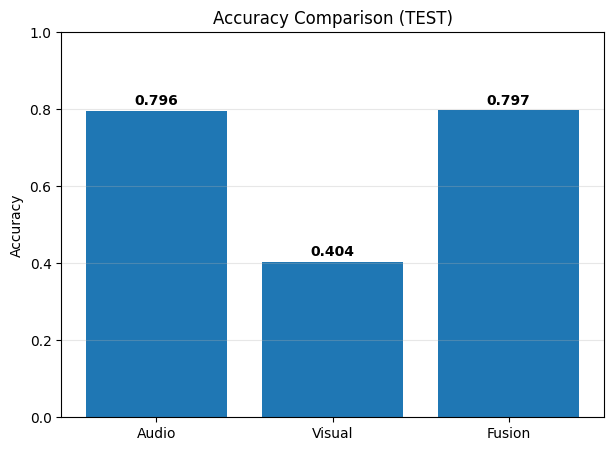

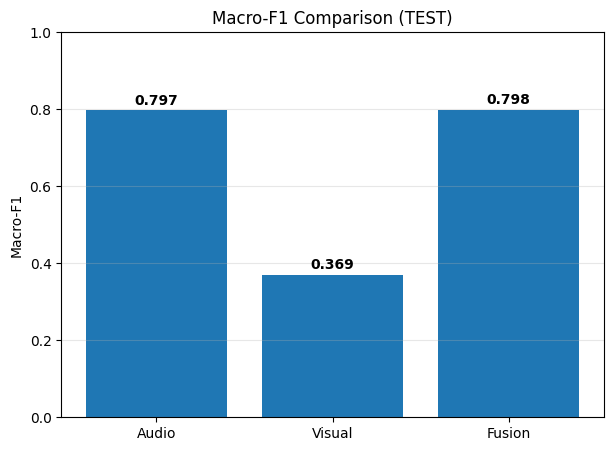

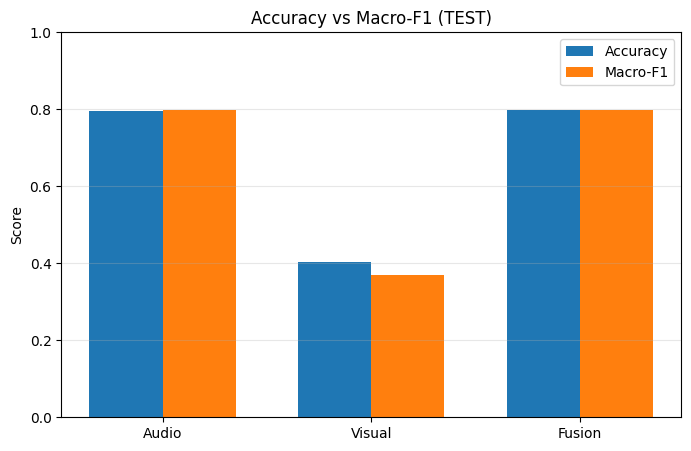

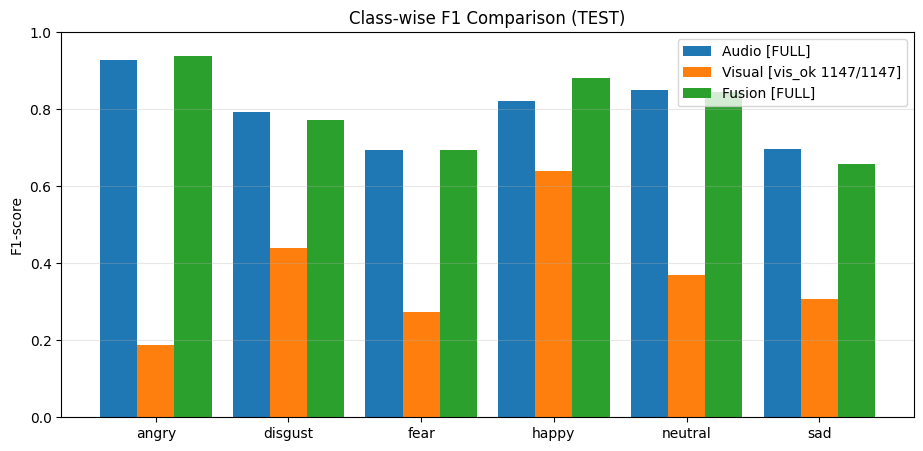

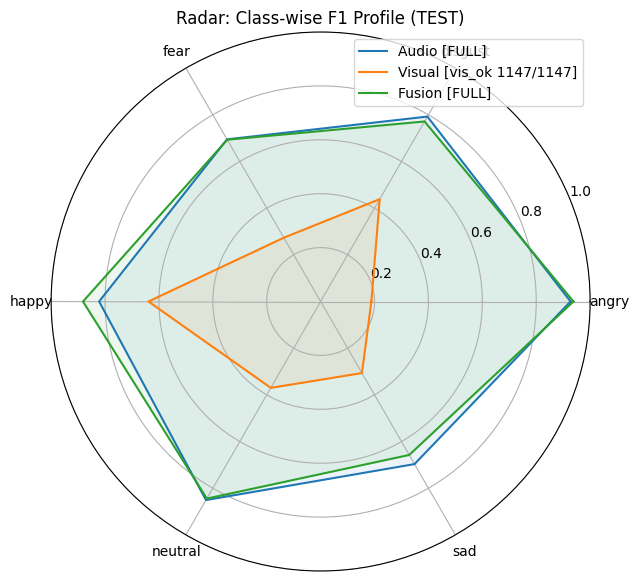

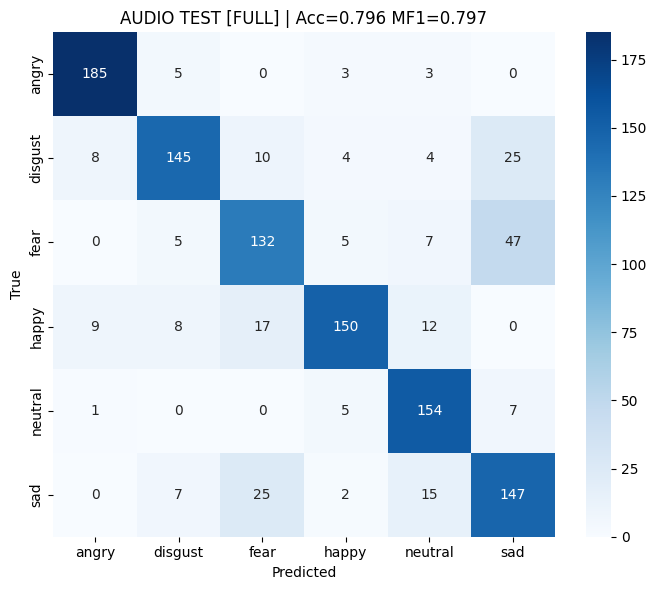

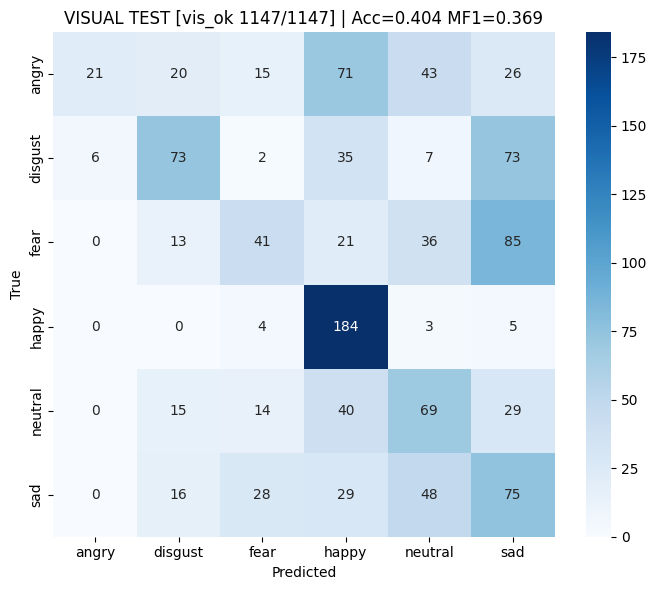

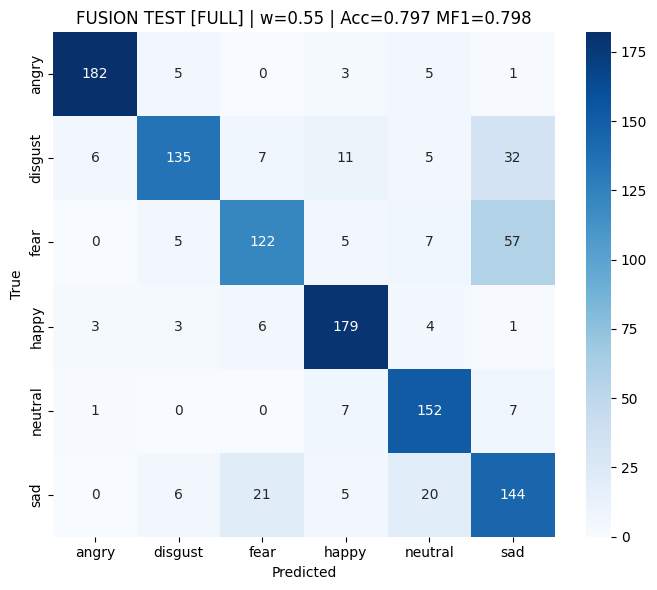

✅ Done: table + all charts generated (fixed & honest).


In [ ]:
# HÜCRE 36
# ONE-CELL FULL REPORT (FIXED)
# - Dynamic w label (W_FINAL)
# - Visual metrics computed ONLY on vis_ok samples
# - Audio/Fusion metrics on full test
# - Confusion matrices: Audio/Fusion full, Visual masked
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# ----------------------------
# 0) Sanity: required columns
# ----------------------------
required_cols = ["y_true", "pred_audio", "pred_visual", "pred_fuse"]
for c in required_cols:
    assert c in out.columns, f"out DataFrame must contain: {c}"

y_true = out["y_true"].values
pred_a = out["pred_audio"].values
pred_v = out["pred_visual"].values
pred_f = out["pred_fuse"].values

# vis_ok yoksa hepsini True say (fallback)
if "vis_ok" in out.columns:
    vis_mask = out["vis_ok"].values.astype(bool)
else:
    vis_mask = np.ones_like(y_true, dtype=bool)

n_total = len(y_true)
n_vis_ok = int(vis_mask.sum())
n_vis_bad = int((~vis_mask).sum())

# ----------------------------
# 1) Helper
# ----------------------------
def get_acc_mf1(y, p):
    return accuracy_score(y, p), f1_score(y, p, average="macro")

def safe_class_report(y, p, labels, target_names):
    # output_dict=True için
    return classification_report(y, p, labels=labels, target_names=target_names,
                                 output_dict=True, zero_division=0)

# ----------------------------
# 2) Metrics (Acc + MacroF1)
# ----------------------------
# Audio/Fusion: full test
acc_a, mf1_a = get_acc_mf1(y_true, pred_a)
acc_f, mf1_f = get_acc_mf1(y_true, pred_f)

# Visual: only vis_ok subset
if n_vis_ok > 0:
    acc_v, mf1_v = get_acc_mf1(y_true[vis_mask], pred_v[vis_mask])
else:
    acc_v, mf1_v = 0.0, 0.0

# Dynamic w label
w_label = f"{W_FINAL:.2f}" if "W_FINAL" in globals() and (W_FINAL is not None) else "?"

summary_df = pd.DataFrame({
    "Model": [
        "Audio (Actor-Indep.) [FULL]",
        f"Visual [vis_ok only: {n_vis_ok}/{n_total}]",
        f"Late Fusion (w={w_label}) [FULL]"
    ],
    "Accuracy": [acc_a, acc_v, acc_f],
    "Macro-F1": [mf1_a, mf1_v, mf1_f]
}).set_index("Model")

display(summary_df.style.format({"Accuracy":"{:.4f}", "Macro-F1":"{:.4f}"}))

print(f"ℹ️ vis_ok summary: {n_vis_ok}/{n_total} (noface or failed: {n_vis_bad})")
print(f"ℹ️ Using w label: {w_label}")

# ----------------------------
# 3) Class-wise F1 (3 models)
# ----------------------------
labels = list(range(len(CLASS_LABELS)))

rep_a = safe_class_report(y_true, pred_a, labels, CLASS_LABELS)
rep_f = safe_class_report(y_true, pred_f, labels, CLASS_LABELS)

# Visual subset report (if available)
if n_vis_ok > 0:
    rep_v = safe_class_report(y_true[vis_mask], pred_v[vis_mask], labels, CLASS_LABELS)
else:
    # empty fallback
    rep_v = {c: {"f1-score": 0.0} for c in CLASS_LABELS}

f1_audio  = [rep_a[c]["f1-score"] for c in CLASS_LABELS]
f1_visual = [rep_v[c]["f1-score"] for c in CLASS_LABELS]
f1_fuse   = [rep_f[c]["f1-score"] for c in CLASS_LABELS]

# ----------------------------
# 4) Plots (Acc/MF1 + Class F1 + Radar)
# ----------------------------
models = ["Audio", "Visual", "Fusion"]
accs = [acc_a, acc_v, acc_f]
mf1s = [mf1_a, mf1_v, mf1_f]

# (A) Accuracy bar
plt.figure(figsize=(7,5))
plt.bar(models, accs)
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison (TEST)")
plt.grid(axis="y", alpha=0.3)
for i,v in enumerate(accs):
    plt.text(i, v+0.015, f"{v:.3f}", ha="center", fontweight="bold")
plt.show()

# (B) Macro-F1 bar
plt.figure(figsize=(7,5))
plt.bar(models, mf1s)
plt.ylim(0,1)
plt.ylabel("Macro-F1")
plt.title("Macro-F1 Comparison (TEST)")
plt.grid(axis="y", alpha=0.3)
for i,v in enumerate(mf1s):
    plt.text(i, v+0.015, f"{v:.3f}", ha="center", fontweight="bold")
plt.show()

# (C) Grouped Acc vs MF1
x = np.arange(len(models))
width = 0.35
plt.figure(figsize=(8,5))
plt.bar(x - width/2, accs, width, label="Accuracy")
plt.bar(x + width/2, mf1s, width, label="Macro-F1")
plt.xticks(x, models)
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Accuracy vs Macro-F1 (TEST)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

# (D) Class-wise F1 bar (Audio vs Visual vs Fusion)
x = np.arange(len(CLASS_LABELS))
w = 0.28
plt.figure(figsize=(11,5))
plt.bar(x - w, f1_audio,  width=w, label="Audio [FULL]")
plt.bar(x,      f1_visual, width=w, label=f"Visual [vis_ok {n_vis_ok}/{n_total}]")
plt.bar(x + w,  f1_fuse,   width=w, label="Fusion [FULL]")
plt.xticks(x, CLASS_LABELS)
plt.ylim(0,1)
plt.ylabel("F1-score")
plt.title("Class-wise F1 Comparison (TEST)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

# (E) Radar chart (Audio/Visual/Fusion)
cats = CLASS_LABELS
angles = [n/float(len(cats))*2*pi for n in range(len(cats))]
angles += angles[:1]

vals_a = f1_audio + f1_audio[:1]
vals_v = f1_visual + f1_visual[:1]
vals_f = f1_fuse  + f1_fuse[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)
ax.plot(angles, vals_a, label="Audio [FULL]")
ax.fill(angles, vals_a, alpha=0.08)
ax.plot(angles, vals_v, label=f"Visual [vis_ok {n_vis_ok}/{n_total}]")
ax.fill(angles, vals_v, alpha=0.08)
ax.plot(angles, vals_f, label="Fusion [FULL]")
ax.fill(angles, vals_f, alpha=0.08)

ax.set_thetagrids(np.degrees(angles[:-1]), cats)
ax.set_ylim(0,1)
plt.title("Radar: Class-wise F1 Profile (TEST)")
plt.legend(loc="upper right")
plt.show()

# ----------------------------
# 5) Confusion Matrices
# ----------------------------
SHOW_CM = True
if SHOW_CM:
    cm_a = confusion_matrix(y_true, pred_a, labels=labels)
    cm_f = confusion_matrix(y_true, pred_f, labels=labels)

    if n_vis_ok > 0:
        cm_v = confusion_matrix(y_true[vis_mask], pred_v[vis_mask], labels=labels)
    else:
        cm_v = np.zeros((len(CLASS_LABELS), len(CLASS_LABELS)), dtype=int)

    if "plot_confusion" in globals():
        plot_confusion(cm_a, CLASS_LABELS, title=f"AUDIO TEST [FULL] | Acc={acc_a:.3f} MF1={mf1_a:.3f}")
        plot_confusion(cm_v, CLASS_LABELS, title=f"VISUAL TEST [vis_ok {n_vis_ok}/{n_total}] | Acc={acc_v:.3f} MF1={mf1_v:.3f}")
        plot_confusion(cm_f, CLASS_LABELS, title=f"FUSION TEST [FULL] | w={w_label} | Acc={acc_f:.3f} MF1={mf1_f:.3f}")
    else:
        # Minimal fallback (no seaborn)
        def show_cm(cm, title):
            plt.figure(figsize=(6,5))
            plt.imshow(cm, interpolation="nearest")
            plt.title(title)
            plt.colorbar()
            ticks = np.arange(len(CLASS_LABELS))
            plt.xticks(ticks, CLASS_LABELS, rotation=45, ha="right")
            plt.yticks(ticks, CLASS_LABELS)
            plt.ylabel("True")
            plt.xlabel("Pred")
            plt.tight_layout()
            plt.show()

        show_cm(cm_a, f"AUDIO CM [FULL] | Acc={acc_a:.3f} MF1={mf1_a:.3f}")
        show_cm(cm_v, f"VISUAL CM [vis_ok {n_vis_ok}/{n_total}] | Acc={acc_v:.3f} MF1={mf1_v:.3f}")
        show_cm(cm_f, f"FUSION CM [FULL] | w={w_label} | Acc={acc_f:.3f} MF1={mf1_f:.3f}")

print("✅ Done: table + all charts generated (fixed & honest).")


In [ ]:
# ============================
# LIVE DEMO: Random TEST video -> Audio + Visual + Fusion prediction
# (AUDIO_CKPT değişkenine bağlı değil, direkt path kullanır)
# ============================

import os, base64
import numpy as np
import torch
import librosa
from IPython.display import display, HTML
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# ---- Sanity (bu 4'ü notebookta zaten ürettin)
assert "test_df" in globals(), "test_df yok! HÜCRE 4'ü çalıştır."
assert "ensure_audio_cached" in globals(), "ensure_audio_cached yok! HÜCRE 6."
assert "predict_visual_proba" in globals(), "predict_visual_proba yok! HÜCRE 17."
assert "CLASS_LABELS" in globals(), "CLASS_LABELS yok! HÜCRE 3."

# ---- Which audio ckpt to use?
AUDIO_CKPT_USED = "/content/drive/MyDrive/experiment_results/best_wav2vec2_speaker_indep.pt"
# istersen bunu aç:
# AUDIO_CKPT_USED = "/content/drive/MyDrive/best_wav2vec2_exp2.pt"

assert os.path.exists(AUDIO_CKPT_USED), f"❌ Audio ckpt yok: {AUDIO_CKPT_USED}"

# ---- Visual inference params: senin sabitlerden al (varsa), yoksa default
conf_th = VIS_CONF_TH if "VIS_CONF_TH" in globals() else 0.5
sample_every = VIS_SAMPLE_EVERY_N_FRAMES if "VIS_SAMPLE_EVERY_N_FRAMES" in globals() else 2
max_samples = VIS_MAX_SAMPLES if "VIS_MAX_SAMPLES" in globals() else 30

# ---- Fusion weight: eğer W_FINAL hesaplandıysa onu kullan, yoksa 0.65
w = float(W_FINAL) if "W_FINAL" in globals() and W_FINAL is not None else 0.65

TARGET_SR = 16000

def show_video(video_path, width=520):
    if not os.path.exists(video_path):
        print("Video yok:", video_path); return
    with open(video_path, "rb") as f:
        data = f.read()
    b64 = base64.b64encode(data).decode("utf-8")
    ext = os.path.splitext(video_path)[1].lower().replace(".", "")
    mime = "video/mp4" if ext in ["mp4","m4v"] else f"video/{ext}" if ext else "video/mp4"
    display(HTML(f"""
    <video width="{width}" controls>
      <source src="data:{mime};base64,{b64}" type="{mime}">
    </video>
    """))

def pretty_topk(proba, k=3):
    idx = np.argsort(-proba)[:k]
    return [(CLASS_LABELS[i], float(proba[i])) for i in idx]

# ---- Load audio model (once per run)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

audio_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=len(CLASS_LABELS)
).to(DEVICE)

ckpt = torch.load(AUDIO_CKPT_USED, map_location="cpu")
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
audio_model.load_state_dict(state, strict=False)
audio_model.eval()

def get_audio_proba_from_row(row, max_sec=3.5):
    wav_path = ensure_audio_cached(row, sr=TARGET_SR)
    max_len = int(TARGET_SR * max_sec)

    if wav_path is None or (not os.path.exists(wav_path)):
        audio = np.zeros(max_len, dtype=np.float32)
    else:
        audio, _ = librosa.load(wav_path, sr=TARGET_SR)
        if len(audio) > max_len:
            audio = audio[:max_len]
        else:
            audio = np.pad(audio, (0, max_len - len(audio)))
        audio = audio.astype(np.float32)

    inputs = processor(
        [audio],
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True
    )
    x = inputs.input_values.to(DEVICE)
    am = inputs.attention_mask.to(DEVICE)

    with torch.no_grad():
        logits = audio_model(input_values=x, attention_mask=am).logits
        p = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()

    p = p / (p.sum() + 1e-9)
    return p  # (6,)

# ---- Pick random test sample
row = test_df.sample(1, random_state=np.random.randint(0, 10_000)).iloc[0].to_dict()
video_path = row["video_path"]

gt_name = row.get("emotion", None)
try:
    gt_label = int(row.get("label", -1))
except Exception:
    gt_label = -1

print("🎬 Random TEST sample")
print("filename:", row.get("filename", "unknown"))
print("GT:", gt_name, "| label:", gt_label)
print("Using:", {"audio_ckpt": AUDIO_CKPT_USED, "w": w, "vis_conf_th": conf_th, "vis_sample_every": sample_every, "vis_max_samples": max_samples})

show_video(video_path)

# ---- Audio
pa = get_audio_proba_from_row(row, max_sec=3.5)
pred_a = int(np.argmax(pa))
print("\n🎧 AUDIO pred:", CLASS_LABELS[pred_a], "| conf:", float(pa.max()))
print("AUDIO top-3:", pretty_topk(pa, 3))

# ---- Visual
pv, vmeta = predict_visual_proba(
    video_path,
    conf_th=conf_th,
    sample_every_n_frames=sample_every,
    max_samples=max_samples
)

if pv is None:
    print("\n🎥 VISUAL: NO FACE / FAIL -> fallback AUDIO")
    print("VISUAL meta:", vmeta)
    pf = pa
else:
    pred_v = int(np.argmax(pv))
    print("\n🎥 VISUAL pred:", CLASS_LABELS[pred_v], "| conf:", float(pv.max()))
    print("VISUAL top-3:", pretty_topk(pv, 3))
    print("VISUAL meta:", vmeta)

    # ---- Fusion
    pf = fuse_probs(pa[None, :], pv[None, :], w)[0]
    pf = pf / (pf.sum() + 1e-9)

pred_f = int(np.argmax(pf))
print("\n🤝 FUSION pred:", CLASS_LABELS[pred_f], "| conf:", float(pf.max()), f"| w={w:.3f}")
print("FUSION top-3:", pretty_topk(pf, 3))


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🎬 Random TEST sample
filename: 1052_WSI_HAP_XX.flv
GT: happy | label: 3
Using: {'audio_ckpt': '/content/drive/MyDrive/experiment_results/best_wav2vec2_speaker_indep.pt', 'w': 0.65, 'vis_conf_th': 0.5, 'vis_sample_every': 2, 'vis_max_samples': 30}



🎧 AUDIO pred: fear | conf: 0.7863272428512573
AUDIO top-3: [('fear', 0.7863272428512573), ('happy', 0.11598805338144302), ('disgust', 0.05159296840429306)]

🎥 VISUAL pred: happy | conf: 0.7874622344970703
VISUAL top-3: [('happy', 0.7874622344970703), ('sad', 0.07054102420806885), ('fear', 0.05895267426967621)]
VISUAL meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}

🤝 FUSION pred: fear | conf: 0.5317461490631104 | w=0.650
FUSION top-3: [('fear', 0.5317461490631104), ('happy', 0.3510040044784546), ('sad', 0.053065985441207886)]


In [ ]:
import os, subprocess, numpy as np, torch, librosa
from IPython.display import display, Video

# -----------------------
# Settings
# -----------------------
N_DEMOS = 10
W_FINAL = float(W_FINAL) if "W_FINAL" in globals() else 0.65
TARGET_SR = 16000
DEMO_DIR = "/content/demo_mp4"
os.makedirs(DEMO_DIR, exist_ok=True)

def fuse_probs(p_audio, p_visual, w_audio):
    return w_audio * p_audio + (1.0 - w_audio) * p_visual

# -----------------------
# 1) FLV -> MP4 (for display)
# -----------------------
def to_playable_mp4(video_path):
    ext = os.path.splitext(video_path)[1].lower()
    if ext in [".mp4", ".m4v"]:
        return video_path

    out_mp4 = os.path.join(
        DEMO_DIR,
        os.path.splitext(os.path.basename(video_path))[0] + ".mp4"
    )
    if os.path.exists(out_mp4) and os.path.getsize(out_mp4) > 0:
        return out_mp4

    cmd = [
        "ffmpeg", "-y",
        "-i", video_path,
        "-c:v", "libx264", "-pix_fmt", "yuv420p",
        "-c:a", "aac", "-b:a", "128k",
        "-movflags", "+faststart",
        out_mp4
    ]
    r = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if r.returncode != 0 or (not os.path.exists(out_mp4)) or os.path.getsize(out_mp4) == 0:
        print("❌ ffmpeg convert failed for:", video_path)
        print(r.stderr.decode("utf-8")[-1200:])
        return None
    return out_mp4

def show_video(video_path, width=720):
    mp4 = to_playable_mp4(video_path)
    if mp4 is None:
        return
    display(Video(mp4, embed=True, width=width))

# -----------------------
# 2) Audio proba (single sample)
# -----------------------
def get_audio_proba_from_row(row_dict, default_max_sec=3.5):
    # ckpt cfg varsa max_sec kullan (daha doğru)
    max_sec = default_max_sec
    if "audio_cfg" in globals() and isinstance(audio_cfg, dict) and "max_sec" in audio_cfg:
        try: max_sec = float(audio_cfg["max_sec"])
        except: pass

    wav_path = ensure_audio_cached(row_dict, sr=TARGET_SR)
    max_len = int(TARGET_SR * max_sec)

    if wav_path is None or (not os.path.exists(wav_path)):
        audio = np.zeros(max_len, dtype=np.float32)
    else:
        audio, _ = librosa.load(wav_path, sr=TARGET_SR)
        if len(audio) > max_len: audio = audio[:max_len]
        else: audio = np.pad(audio, (0, max_len - len(audio)))
        audio = audio.astype(np.float32)

    inputs = processor(
        [audio],
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True
    )
    x = inputs.input_values.to(audio_model.device)
    am = inputs.attention_mask.to(audio_model.device)

    with torch.no_grad():
        logits = audio_model(input_values=x, attention_mask=am).logits
        p = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()

    p = p / (p.sum() + 1e-9)
    return p  # (6,)

def topk(proba, k=3):
    idx = np.argsort(-proba)[:k]
    return [(CLASS_LABELS[i], float(proba[i])) for i in idx]

# -----------------------
# 3) Run 5 demos
# -----------------------
samples = test_df.sample(N_DEMOS, random_state=np.random.randint(0, 10_000)).to_dict("records")

print(f"🎬 DEMO COUNT = {N_DEMOS} | w={W_FINAL}")
for i, row in enumerate(samples, 1):
    video_path = row["video_path"]
    fname = row.get("filename", os.path.basename(video_path))
    gt = row.get("emotion", None)
    if gt is None or str(gt) == "nan":
        try:
            gt_id = int(row.get("label", -1))
            gt = CLASS_LABELS[gt_id] if 0 <= gt_id < len(CLASS_LABELS) else "unknown"
        except:
            gt = "unknown"

    print("\n" + "="*70)
    print(f"[{i}] {fname}")
    print("GT:", gt)

    # show video (mp4 converted)
    show_video(video_path, width=720)

    # AUDIO
    pa = get_audio_proba_from_row(row)
    pred_a = int(np.argmax(pa))
    print("🎧 AUDIO:", CLASS_LABELS[pred_a], "| conf:", float(pa.max()))
    print("   top-3:", topk(pa, 3))

    # VISUAL
    pv, vmeta = predict_visual_proba(
        video_path,
        conf_th=VIS_CONF_TH,
        sample_every_n_frames=VIS_SAMPLE_EVERY_N_FRAMES,
        max_samples=VIS_MAX_SAMPLES
    )

    if pv is None:
        print("🎥 VISUAL: NO FACE -> fallback audio")
        print("   meta:", vmeta)
        pf = pa
    else:
        pred_v = int(np.argmax(pv))
        print("🎥 VISUAL:", CLASS_LABELS[pred_v], "| conf:", float(pv.max()))
        print("   top-3:", topk(pv, 3))
        print("   meta:", vmeta)

        # FUSION
        pf = fuse_probs(pa, pv, W_FINAL)
        pf = pf / (pf.sum() + 1e-9)

    pred_f = int(np.argmax(pf))
    print("🤝 FUSION:", CLASS_LABELS[pred_f], "| conf:", float(pf.max()))
    print("   top-3:", topk(pf, 3))


🎬 DEMO COUNT = 10 | w=0.65

[1] 1021_ITH_SAD_XX.flv
GT: sad


🎧 AUDIO: sad | conf: 0.8309801816940308
   top-3: [('sad', 0.8309801816940308), ('fear', 0.08994267135858536), ('neutral', 0.07107272744178772)]
🎥 VISUAL: neutral | conf: 0.5370426177978516
   top-3: [('neutral', 0.5370426177978516), ('happy', 0.41231444478034973), ('fear', 0.046722397208213806)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: sad | conf: 0.5410597324371338
   top-3: [('sad', 0.5410597324371338), ('neutral', 0.23416221141815186), ('happy', 0.1452140212059021)]

[2] 1024_IEO_DIS_MD.flv
GT: disgust


🎧 AUDIO: disgust | conf: 0.7037376165390015
   top-3: [('disgust', 0.7037376165390015), ('angry', 0.2758713960647583), ('happy', 0.011959677562117577)]
🎥 VISUAL: sad | conf: 0.7579277157783508
   top-3: [('sad', 0.7579277157783508), ('disgust', 0.1345582902431488), ('happy', 0.09649905562400818)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: disgust | conf: 0.5045248866081238
   top-3: [('disgust', 0.5045248866081238), ('sad', 0.2685512900352478), ('angry', 0.18086186051368713)]

[3] 1030_ITS_FEA_XX.flv
GT: fear


🎧 AUDIO: fear | conf: 0.9253918528556824
   top-3: [('fear', 0.9253918528556824), ('happy', 0.06329214572906494), ('sad', 0.009725335985422134)]
🎥 VISUAL: sad | conf: 0.27404722571372986
   top-3: [('sad', 0.27404722571372986), ('disgust', 0.24552589654922485), ('happy', 0.17414379119873047)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: fear | conf: 0.6537402868270874
   top-3: [('fear', 0.6537402868270874), ('sad', 0.1022379919886589), ('happy', 0.10209022462368011)]

[4] 1061_IOM_ANG_XX.flv
GT: angry


🎧 AUDIO: angry | conf: 0.9779648780822754
   top-3: [('angry', 0.9779648780822754), ('disgust', 0.01952003315091133), ('happy', 0.0015331580070778728)]
🎥 VISUAL: neutral | conf: 0.41505396366119385
   top-3: [('neutral', 0.41505396366119385), ('angry', 0.20135600864887238), ('happy', 0.19735561311244965)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: angry | conf: 0.7061517834663391
   top-3: [('angry', 0.7061517834663391), ('neutral', 0.14565958082675934), ('happy', 0.0700710192322731)]

[5] 1072_ITS_DIS_XX.flv
GT: disgust


🎧 AUDIO: happy | conf: 0.9547654986381531
   top-3: [('happy', 0.9547654986381531), ('fear', 0.025384442880749702), ('disgust', 0.015942279249429703)]
🎥 VISUAL: disgust | conf: 0.8641351461410522
   top-3: [('disgust', 0.8641351461410522), ('sad', 0.13092581927776337), ('angry', 0.002668406581506133)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: happy | conf: 0.620699405670166
   top-3: [('happy', 0.620699405670166), ('disgust', 0.3128097951412201), ('sad', 0.04659100994467735)]

[6] 1085_IOM_FEA_XX.flv
GT: fear


🎧 AUDIO: sad | conf: 0.704909086227417
   top-3: [('sad', 0.704909086227417), ('fear', 0.2619774043560028), ('disgust', 0.01798451691865921)]
🎥 VISUAL: sad | conf: 0.6303001046180725
   top-3: [('sad', 0.6303001046180725), ('disgust', 0.3069128394126892), ('fear', 0.02835053764283657)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: sad | conf: 0.6787959933280945
   top-3: [('sad', 0.6787959933280945), ('fear', 0.1802079975605011), ('disgust', 0.11910943686962128)]

[7] 1022_TSI_NEU_XX.flv
GT: neutral


🎧 AUDIO: neutral | conf: 0.990530788898468
   top-3: [('neutral', 0.990530788898468), ('happy', 0.0037117847241461277), ('angry', 0.0028713883366435766)]
🎥 VISUAL: neutral | conf: 0.6114795804023743
   top-3: [('neutral', 0.6114795804023743), ('happy', 0.27272680401802063), ('disgust', 0.0679340735077858)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: neutral | conf: 0.8578629493713379
   top-3: [('neutral', 0.8578629493713379), ('happy', 0.09786705672740936), ('disgust', 0.024372197687625885)]

[8] 1053_MTI_HAP_XX.flv
GT: happy


🎧 AUDIO: happy | conf: 0.8700370192527771
   top-3: [('happy', 0.8700370192527771), ('angry', 0.10663657635450363), ('fear', 0.0190317053347826)]
🎥 VISUAL: happy | conf: 0.7392058968544006
   top-3: [('happy', 0.7392058968544006), ('neutral', 0.17486076056957245), ('fear', 0.0464615598320961)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: happy | conf: 0.8242461681365967
   top-3: [('happy', 0.8242461681365967), ('angry', 0.07094545662403107), ('neutral', 0.06177585944533348)]

[9] 1021_TSI_ANG_XX.flv
GT: angry


🎧 AUDIO: angry | conf: 0.9962043166160583
   top-3: [('angry', 0.9962043166160583), ('disgust', 0.0026925683487206697), ('happy', 0.000572388235013932)]
🎥 VISUAL: happy | conf: 0.5204419493675232
   top-3: [('happy', 0.5204419493675232), ('neutral', 0.4774538278579712), ('sad', 0.0009003555169329047)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: angry | conf: 0.6475942134857178
   top-3: [('angry', 0.6475942134857178), ('happy', 0.18252673745155334), ('neutral', 0.16735704243183136)]

[10] 1024_DFA_DIS_XX.flv
GT: disgust


🎧 AUDIO: disgust | conf: 0.8803723454475403
   top-3: [('disgust', 0.8803723454475403), ('angry', 0.06403091549873352), ('neutral', 0.035004064440727234)]
🎥 VISUAL: sad | conf: 0.786152720451355
   top-3: [('sad', 0.786152720451355), ('neutral', 0.08921529352664948), ('happy', 0.06613574922084808)]
   meta: {'frames_used': 30, 'noface_frames': 0, 'conf_th': 0.5, 'sample_every_n_frames': 2, 'max_samples': 30}
🤝 FUSION: disgust | conf: 0.581200122833252
   top-3: [('disgust', 0.581200122833252), ('sad', 0.28544822335243225), ('neutral', 0.05397799611091614)]


In [ ]:
from transformers import Wav2Vec2Processor

# audio model hangi base ile çıktıysa onunla aynı olsun (genelde 960h kullanmışsın)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
print("✅ processor ready")


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

✅ processor ready


In [ ]:
import numpy as np

def fuse_probs(p_audio, p_visual, w_audio: float):
    """
    p_audio: (N,C) veya (C,)
    p_visual:(N,C) veya (C,)
    return:  aynı shape
    """
    return w_audio * p_audio + (1.0 - w_audio) * p_visual


In [ ]:
# ============================
# VISUAL SINGLE-SOURCE SETUP
# - face_net
# - preprocess_face
# - _best_face_roi
# - emotion_model
# ============================

import os, urllib.request
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# ---- VIS params (senin sabitlerin)
VIS_CONF_TH = 0.5
VIS_SAMPLE_EVERY_N_FRAMES = 2
VIS_MAX_SAMPLES = 30

# ---- 1) Face detector (OpenCV SSD DNN)
detector_dir = "/content/face_detector_model"
os.makedirs(detector_dir, exist_ok=True)

prototxt_path   = os.path.join(detector_dir, "deploy.prototxt.txt")
caffemodel_path = os.path.join(detector_dir, "res10_300x300_ssd_iter_140000.caffemodel")

if (not os.path.exists(prototxt_path)) or (not os.path.exists(caffemodel_path)):
    print("⚠️ Face detector eksik, indiriyorum...")
    url_proto = "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"
    url_model = "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel"
    urllib.request.urlretrieve(url_proto, prototxt_path)
    urllib.request.urlretrieve(url_model, caffemodel_path)
    print("✅ indirildi.")

face_net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
print("✅ face_net ready")

# ---- 2) preprocess (BGR -> RGB, resize, /255)
def preprocess_face(face_img, target_size=(224, 224)):
    if face_img is None or face_img.size == 0:
        return None
    img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)
    img_norm = img_resized.astype("float32") / 255.0
    return np.expand_dims(img_norm, axis=0)  # (1,224,224,3)

# ---- 3) best ROI from frame
def _best_face_roi(frame, conf_th=VIS_CONF_TH, min_size=20):
    if frame is None:
        return None

    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(
        cv2.resize(frame, (300, 300)),
        1.0,
        (300, 300),
        (104.0, 177.0, 123.0)
    )
    face_net.setInput(blob)
    detections = face_net.forward()

    best = None  # (conf, sx, sy, ex, ey)
    for i in range(detections.shape[2]):
        conf = float(detections[0, 0, i, 2])
        if conf < conf_th:
            continue

        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (sx, sy, ex, ey) = box.astype(int)

        sx, sy = max(0, sx), max(0, sy)
        ex, ey = min(w, ex), min(h, ey)

        if (ex - sx) < min_size or (ey - sy) < min_size:
            continue

        if (best is None) or (conf > best[0]):
            best = (conf, sx, sy, ex, ey)

    if best is None:
        return None

    _, sx, sy, ex, ey = best
    roi = frame[sy:ey, sx:ex]
    if roi is None or roi.size == 0:
        return None
    return roi

# ---- 4) load keras model
VISUAL_MODEL_PATH = "/content/drive/MyDrive/best_final_model.keras"
assert os.path.exists(VISUAL_MODEL_PATH), f"❌ Visual model yok: {VISUAL_MODEL_PATH}"

emotion_model = load_model(VISUAL_MODEL_PATH)
print("✅ Visual model loaded:", emotion_model.input_shape, "->", emotion_model.output_shape)


⚠️ Face detector eksik, indiriyorum...
✅ indirildi.
✅ face_net ready
✅ Visual model loaded: (None, 224, 224, 3) -> (None, 6)


Late Fusion (Weighted Average) + FULL metrik/CM

Fusion için en basit ve güçlü baseline:

pfuse​=w⋅paudio​+(1−w)⋅pvisual​

Ama kritik nokta: Visual bazı videolarda proba veremiyor (no face).
Fallback kuralı: visual yoksa p_fuse = p_audio (mantıklı ve temiz).

In [ ]:
# pip install huggingface_hub
from huggingface_hub import login, HfApi

from huggingface_hub import login
login()  # interactive login, no hardcoded token


api = HfApi()

# MODEL repo upload
api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/experiment_results/best_wav2vec2_speaker_indep.pt",
    path_in_repo="checkpoints/best_wav2vec2_speaker_indep.pt",
    repo_id="Seldarzu/crema_d_MER_arzuSeldaAvci_ayazAktas",
    repo_type="model",
)

api.upload_file(
    path_or_fileobj="/content/drive/MyDrive/best_final_model.keras",  # veya visual.pt
    path_in_repo="checkpoints/best_final_model.keras",
    repo_id="Seldarzu/crema_d_MER_arzuSeldaAvci_ayazAktas",
    repo_type="model",
)

print("✅ upload bitti")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...wav2vec2_speaker_indep.pt:   0%|          |  600kB /  378MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ve/best_final_model.keras:   4%|3         | 4.02MB /  103MB            

✅ upload bitti


In [ ]:
from huggingface_hub import login
login(..)

# 3) Klasörü dataset repo'ya upload et
from huggingface_hub import HfApi

api = HfApi()

LOCAL_FOLDER = "/content/drive/MyDrive/derin_test_MultimodalER_arzu_ayaz"  # sizin Drive klasörü
REPO_ID = "Seldarzu/crema_d_Fusion_Test_Videos"                            # dataset repo

api.upload_folder(
    folder_path=LOCAL_FOLDER,
    repo_id=REPO_ID,
    repo_type="dataset",
    path_in_repo="demos",                 # HF dataset içinde "demos/" altına koyar (istersen "" yap)
    commit_message="Upload demo videos (derin_test_MultimodalER_arzu_ayaz)"
)

print("✅ Upload tamamlandı:", REPO_ID)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._ayaz/1003_IEO_NEU_XX.flv:  10%|9         | 27.2kB /  277kB            

  ..._ayaz/1003_IWW_HAP_XX.flv:  10%|9         | 43.8kB /  446kB            

  ..._ayaz/1003_TSI_DIS_XX.flv:  10%|9         | 45.3kB /  462kB            

  ..._ayaz/1021_IOM_SAD_XX.flv:  10%|9         | 34.0kB /  347kB            

  ..._ayaz/1021_ITH_SAD_XX.flv:  10%|9         | 36.7kB /  374kB            

  ..._ayaz/1021_IWW_NEU_XX.flv:  10%|9         | 33.8kB /  344kB            

  ..._ayaz/1022_IOM_HAP_XX.flv:  10%|9         | 32.0kB /  326kB            

  ..._ayaz/1022_IWW_DIS_XX.flv:  10%|9         | 30.3kB /  309kB            

  ..._ayaz/1024_DFA_HAP_XX.flv:  10%|9         | 24.5kB /  249kB            

  ..._ayaz/1024_WSI_FEA_XX.flv:  10%|9         | 35.0kB /  356kB            

✅ Upload tamamlandı: Seldarzu/crema_d_Fusion_Test_Videos


# **TEST İÇİN LÜTFEN AŞAĞIDAKİ HÜCREYİ ÇALIŞTIRIN !**

In [ ]:
# ============================
#   ONE-CELL FINAL DEMO (FIXED VIDEO PLAYBACK + ANNOTATION)
# ============================

import os, sys, subprocess, random, re, base64
from pathlib import Path
import numpy as np

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# ============================
# ✅ DEPENDENCY INSTALL
# ============================
import sys, subprocess

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Core deps for your demo
pip_install([
    "huggingface_hub>=0.23.0",
    "transformers>=4.40.0",
    "torch",
    "librosa",
    "opencv-python",
    "tensorflow",
    "ipython",
    "imageio-ffmpeg"
])

print("✅ Dependencies installed.")


import torch, librosa, cv2
from huggingface_hub import hf_hub_download, HfApi
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from tensorflow.keras.models import load_model
from IPython.display import HTML, display
import imageio_ffmpeg

MODEL_REPO = "Seldarzu/crema_d_MER_arzuSeldaAvci_ayazAktas"
DATA_REPO  = "Seldarzu/crema_d_Fusion_Test_Videos"

AUDIO_CKPT_IN_REPO  = "checkpoints/best_wav2vec2_speaker_indep.pt"
VISUAL_CKPT_IN_REPO = "checkpoints/best_final_model.keras"

CLASS_LABELS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
EMO_MAP = {"ANG":"angry","DIS":"disgust","FEA":"fear","HAP":"happy","NEU":"neutral","SAD":"sad"}

N_DEMOS = 10
W_FINAL = 0.65
TARGET_SR = 16000
MAX_SEC = 3.5

SAMPLE_EVERY_N_FRAMES = 2
MAX_FACE_SAMPLES = 30
FACE_MIN_SIZE = (60, 60)

TMP = Path("_tmp_demo")
TMP.mkdir(exist_ok=True)

FFMPEG = imageio_ffmpeg.get_ffmpeg_exe()

def topk(proba, k=3):
    idx = np.argsort(-proba)[:k]
    return [(CLASS_LABELS[i], float(proba[i])) for i in idx]

def fuse_probs(p_audio, p_visual, w_audio):
    p = w_audio * p_audio + (1.0 - w_audio) * p_visual
    return p / (p.sum() + 1e-9)

def parse_gt_from_filename(fname: str):
    m = re.search(r"_(ANG|DIS|FEA|HAP|NEU|SAD)_", fname)
    return EMO_MAP.get(m.group(1), "unknown") if m else "unknown"

def ensure_browser_mp4(in_path: Path) -> Path:
    out_path = TMP / (in_path.stem + "_browser.mp4")
    if out_path.exists() and out_path.stat().st_size > 0:
        return out_path
    cmd = [
        FFMPEG, "-y",
        "-i", str(in_path),
        "-c:v", "libx264", "-pix_fmt", "yuv420p",
        "-preset", "veryfast", "-crf", "23",
        "-c:a", "aac", "-b:a", "128k",
        "-movflags", "+faststart",
        str(out_path)
    ]
    r = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if r.returncode != 0 or (not out_path.exists()) or out_path.stat().st_size == 0:
        print("❌ browser mp4 encode failed:", in_path.name)
        print(r.stderr.decode("utf-8")[-1200:])
        return in_path
    return out_path

def show_video_safe(path: Path, width=720, autoplay=False, loop=False, muted=True):
    p = ensure_browser_mp4(path)
    data = p.read_bytes()
    b64 = base64.b64encode(data).decode("utf-8")
    auto = "autoplay" if autoplay else ""
    lp = "loop" if loop else ""
    mut = "muted" if muted else ""
    html = f"""
    <video width="{width}" controls {auto} {lp} {mut}>
      <source src="data:video/mp4;base64,{b64}" type="video/mp4">
      Your browser does not support the video tag.
    </video>
    """
    display(HTML(html))

# Download models
audio_ckpt_path  = hf_hub_download(repo_id=MODEL_REPO, filename=AUDIO_CKPT_IN_REPO, repo_type="model")
visual_ckpt_path = hf_hub_download(repo_id=MODEL_REPO, filename=VISUAL_CKPT_IN_REPO, repo_type="model")

print("✅ Downloaded ckpts:")
print("  AUDIO :", audio_ckpt_path)
print("  VISUAL:", visual_ckpt_path)

# Download demos
api = HfApi()
files = api.list_repo_files(repo_id=DATA_REPO, repo_type="dataset")
video_files = [f for f in files if f.startswith("demos/") and re.search(r"\.(mp4|m4v|mov|avi|flv)$", f, re.IGNORECASE)]
if not video_files:
    raise RuntimeError(f"❌ No videos found under demos/ in {DATA_REPO}")

random.shuffle(video_files)
video_files = video_files[:min(N_DEMOS, len(video_files))]
raw_demo_paths = [Path(hf_hub_download(repo_id=DATA_REPO, filename=vf, repo_type="dataset")) for vf in video_files]
print(f"✅ Demo files ({len(raw_demo_paths)}):", [p.name for p in raw_demo_paths])

# Load audio
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
audio_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base-960h",
    num_labels=len(CLASS_LABELS),
    problem_type="single_label_classification"
)

state = torch.load(audio_ckpt_path, map_location="cpu")
if isinstance(state, dict) and "state_dict" in state:
    state = state["state_dict"]
if isinstance(state, dict) and "model" in state:
    state = state["model"]
audio_model.load_state_dict(state, strict=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
audio_model.to(device).eval()
print("✅ Audio model on:", device)

# Load visual
visual_model = load_model(visual_ckpt_path, compile=False)
print("✅ Visual model loaded (Keras).")

# Audio extract + proba
def extract_wav(video_path: Path, out_wav: Path, sr=16000):
    cmd = [FFMPEG, "-y", "-i", str(video_path), "-vn", "-ac", "1", "-ar", str(sr), "-f", "wav", str(out_wav)]
    r = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if r.returncode != 0 or (not out_wav.exists()) or out_wav.stat().st_size == 0:
        print("❌ audio extract failed:", video_path.name)
        print(r.stderr.decode("utf-8")[-800:])
        return None
    return out_wav

def get_audio_proba(video_path: Path, max_sec=3.5):
    wav_path = TMP / (video_path.stem + f"_{TARGET_SR}.wav")
    if not wav_path.exists():
        extract_wav(video_path, wav_path, sr=TARGET_SR)

    max_len = int(TARGET_SR * max_sec)
    if wav_path.exists():
        audio, _ = librosa.load(str(wav_path), sr=TARGET_SR)
    else:
        audio = np.zeros(max_len, dtype=np.float32)

    if len(audio) > max_len: audio = audio[:max_len]
    else: audio = np.pad(audio, (0, max_len - len(audio)))
    audio = audio.astype(np.float32)

    inputs = processor([audio], sampling_rate=TARGET_SR, return_tensors="pt", padding=True, return_attention_mask=True)
    x  = inputs.input_values.to(device)
    am = inputs.attention_mask.to(device)

    with torch.no_grad():
        logits = audio_model(input_values=x, attention_mask=am).logits
        p = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()
    return p / (p.sum() + 1e-9)

# Visual + annotate
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def preprocess_face_bgr(face_bgr, size=(224,224)):
    x = cv2.resize(face_bgr, size)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.astype(np.float32) / 255.0
    return np.expand_dims(x, axis=0)

def put_text_shadow(img, text, org, font, scale, color, thickness, shadow_color=(255,255,255)):
    x, y = org
    cv2.putText(img, text, (x+1, y+1), font, scale, shadow_color, thickness+2, cv2.LINE_AA)
    cv2.putText(img, text, (x, y), font, scale, color, thickness, cv2.LINE_AA)

def annotate_video(video_path: Path, gt_label: str, pa: np.ndarray):
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        return None, None, {"reason":"open failed"}

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps is None or fps <= 1:
        fps = 25

    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    raw_out = TMP / f"{video_path.stem}_annot_raw.mp4"
    writer = cv2.VideoWriter(str(raw_out), cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))

    audio_pred = CLASS_LABELS[int(np.argmax(pa))]
    audio_conf = float(pa.max())

    preds_visual = []
    frames = 0
    faces_seen = 0

    font = cv2.FONT_HERSHEY_SIMPLEX

    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frames += 1

        line2_y = H - 20
        line1_y = H - 50
        x0 = 10

        put_text_shadow(frame, f"REAL: {gt_label}", (x0, line1_y), font, 0.75, (0,0,0), 2)             # black
        put_text_shadow(frame, f"AUDIO: {audio_pred} ({audio_conf:.2f})", (x0, line2_y), font, 0.75, (0,0,0), 2)  # black

        if frames % SAMPLE_EVERY_N_FRAMES == 0 and faces_seen < MAX_FACE_SAMPLES:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=FACE_MIN_SIZE)

            if len(faces) > 0:
                (x,y,w,h) = sorted(faces, key=lambda t: t[2]*t[3], reverse=True)[0]
                face = frame[y:y+h, x:x+w]

                xin = preprocess_face_bgr(face, (224,224))
                pv = visual_model.predict(xin, verbose=0)[0]
                pv = np.array(pv, dtype=np.float32)
                pv = pv / (pv.sum() + 1e-9)

                preds_visual.append(pv)
                faces_seen += 1

                vis_pred = CLASS_LABELS[int(np.argmax(pv))]
                vis_conf = float(pv.max())

                cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,0), 2)

                label_y = max(25, y-10)
                put_text_shadow(frame, f"VIS: {vis_pred} ({vis_conf:.2f})", (x, label_y), font, 0.7, (0,0,0), 2)

        writer.write(frame)

    cap.release()
    writer.release()

    if len(preds_visual) == 0:
        pv_mean = None
        meta = {"frames":frames, "faces_seen":0, "reason":"no face detected"}
    else:
        pv_mean = np.mean(np.stack(preds_visual, axis=0), axis=0)
        pv_mean = pv_mean / (pv_mean.sum() + 1e-9)
        meta = {"frames":frames, "faces_seen":faces_seen}

    annotated_h264 = ensure_browser_mp4(raw_out)
    return annotated_h264, pv_mean, meta

# RUN
print(f"\n🎬 FINAL DEMO | n={len(raw_demo_paths)} | w={W_FINAL} | device={device}\n")

for i, raw_path in enumerate(raw_demo_paths, 1):
    gt = parse_gt_from_filename(raw_path.name)

    print("\n" + "="*85)
    print(f"[{i}] {raw_path.name} | REAL={gt}")

    input_mp4 = ensure_browser_mp4(raw_path)

    pa = get_audio_proba(input_mp4, max_sec=MAX_SEC)
    print("🎧 AUDIO :", CLASS_LABELS[int(np.argmax(pa))], "| conf:", float(pa.max()))
    print("   top-3:", topk(pa, 3))

    out_vid, pv, meta = annotate_video(input_mp4, gt, pa)
    if out_vid is not None:
        print("🎞️ Annotated video (playable):")
        show_video_safe(out_vid, width=720)

    if pv is None:
        print("🎥 VISUAL: NO FACE -> fallback audio")
        print("   meta:", meta)
        pf = pa
    else:
        print("🎥 VISUAL:", CLASS_LABELS[int(np.argmax(pv))], "| conf:", float(pv.max()))
        print("   top-3:", topk(pv, 3))
        print("   meta:", meta)
        pf = fuse_probs(pa, pv, W_FINAL)

    print("   FUSION:", CLASS_LABELS[int(np.argmax(pf))], "| conf:", float(pf.max()))
    print("   top-3:", topk(pf, 3))

print("\n✅ DONE.")


✅ Dependencies installed.
✅ Downloaded ckpts:
  AUDIO : /root/.cache/huggingface/hub/models--Seldarzu--crema_d_MER_arzuSeldaAvci_ayazAktas/snapshots/b185d05c1e9f150232d729fc6a3ef63010734520/checkpoints/best_wav2vec2_speaker_indep.pt
  VISUAL: /root/.cache/huggingface/hub/models--Seldarzu--crema_d_MER_arzuSeldaAvci_ayazAktas/snapshots/b185d05c1e9f150232d729fc6a3ef63010734520/checkpoints/best_final_model.keras


demos/1061_ITH_HAP_XX.flv:   0%|          | 0.00/276k [00:00<?, ?B/s]

demos/1083_IOM_HAP_XX.flv:   0%|          | 0.00/261k [00:00<?, ?B/s]

✅ Demo files (10): ['1022_IOM_HAP_XX.flv', '1003_TSI_DIS_XX.flv', '1021_IOM_SAD_XX.flv', '1075_IOM_NEU_XX.flv', '1024_WSI_FEA_XX.flv', '1061_ITH_HAP_XX.flv', '1085_TIE_ANG_XX.flv', '1021_IWW_NEU_XX.flv', '1052_TIE_FEA_XX.flv', '1083_IOM_HAP_XX.flv']


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Audio model on: cuda
✅ Visual model loaded (Keras).

🎬 FINAL DEMO | n=10 | w=0.65 | device=cuda


[1] 1022_IOM_HAP_XX.flv | REAL=happy
🎧 AUDIO : happy | conf: 0.9839062094688416
   top-3: [('happy', 0.9839062094688416), ('fear', 0.00914557185024023), ('disgust', 0.003238787641748786)]
🎞️ Annotated video (playable):


🎥 VISUAL: happy | conf: 0.7507219910621643
   top-3: [('happy', 0.7507219910621643), ('disgust', 0.14732496440410614), ('neutral', 0.08768931031227112)]
   meta: {'frames': 74, 'faces_seen': 30}
🤝 FUSION: happy | conf: 0.9022917151451111
   top-3: [('happy', 0.9022917151451111), ('disgust', 0.053668949753046036), ('neutral', 0.0321059450507164)]

[2] 1003_TSI_DIS_XX.flv | REAL=disgust
🎧 AUDIO : disgust | conf: 0.9505972266197205
   top-3: [('disgust', 0.9505972266197205), ('angry', 0.019348539412021637), ('neutral', 0.01216460857540369)]
🎞️ Annotated video (playable):


🎥 VISUAL: disgust | conf: 0.9082907438278198
   top-3: [('disgust', 0.9082907438278198), ('angry', 0.0571182556450367), ('happy', 0.021261876448988914)]
   meta: {'frames': 109, 'faces_seen': 30}
🤝 FUSION: disgust | conf: 0.9357900023460388
   top-3: [('disgust', 0.9357900023460388), ('angry', 0.03256794437766075), ('happy', 0.01184894796460867)]

[3] 1021_IOM_SAD_XX.flv | REAL=sad
🎧 AUDIO : sad | conf: 0.7912263870239258
   top-3: [('sad', 0.7912263870239258), ('disgust', 0.14960776269435883), ('fear', 0.05659794807434082)]
🎞️ Annotated video (playable):


🎥 VISUAL: neutral | conf: 0.6808867454528809
   top-3: [('neutral', 0.6808867454528809), ('happy', 0.30004921555519104), ('fear', 0.01755317859351635)]
   meta: {'frames': 80, 'faces_seen': 30}
🤝 FUSION: sad | conf: 0.5144655704498291
   top-3: [('sad', 0.5144655704498291), ('neutral', 0.23941491544246674), ('happy', 0.105288065969944)]

[4] 1075_IOM_NEU_XX.flv | REAL=neutral
🎧 AUDIO : neutral | conf: 0.9957508444786072
   top-3: [('neutral', 0.9957508444786072), ('sad', 0.0031171003356575966), ('disgust', 0.0004980107769370079)]
🎞️ Annotated video (playable):


🎥 VISUAL: neutral | conf: 0.7077563405036926
   top-3: [('neutral', 0.7077563405036926), ('fear', 0.16934555768966675), ('happy', 0.06097031012177467)]
   meta: {'frames': 64, 'faces_seen': 30}
🤝 FUSION: neutral | conf: 0.8949527144432068
   top-3: [('neutral', 0.8949527144432068), ('fear', 0.05930188670754433), ('happy', 0.021556179970502853)]

[5] 1024_WSI_FEA_XX.flv | REAL=fear
🎧 AUDIO : fear | conf: 0.9664391279220581
   top-3: [('fear', 0.9664391279220581), ('sad', 0.02367248199880123), ('happy', 0.006980204954743385)]
🎞️ Annotated video (playable):


🎥 VISUAL: sad | conf: 0.9565856456756592
   top-3: [('sad', 0.9565856456756592), ('angry', 0.013948584906756878), ('disgust', 0.01357108261436224)]
   meta: {'frames': 84, 'faces_seen': 30}
🤝 FUSION: fear | conf: 0.6321321129798889
   top-3: [('fear', 0.6321321129798889), ('sad', 0.3501920998096466), ('disgust', 0.006431119050830603)]

[6] 1061_ITH_HAP_XX.flv | REAL=happy
🎧 AUDIO : happy | conf: 0.9851842522621155
   top-3: [('happy', 0.9851842522621155), ('neutral', 0.011991503648459911), ('angry', 0.0011154303792864084)]
🎞️ Annotated video (playable):


🎥 VISUAL: happy | conf: 0.6082452535629272
   top-3: [('happy', 0.6082452535629272), ('sad', 0.3245242238044739), ('neutral', 0.06426974385976791)]
   meta: {'frames': 68, 'faces_seen': 30}
🤝 FUSION: happy | conf: 0.853255569934845
   top-3: [('happy', 0.853255569934845), ('sad', 0.11366864293813705), ('neutral', 0.03028888627886772)]

[7] 1085_TIE_ANG_XX.flv | REAL=angry
🎧 AUDIO : angry | conf: 0.9981204867362976
   top-3: [('angry', 0.9981204867362976), ('disgust', 0.0008291855338029563), ('happy', 0.000602147716563195)]
🎞️ Annotated video (playable):


🎥 VISUAL: happy | conf: 0.43626341223716736
   top-3: [('happy', 0.43626341223716736), ('neutral', 0.29996755719184875), ('sad', 0.1571880728006363)]
   meta: {'frames': 82, 'faces_seen': 30}
🤝 FUSION: angry | conf: 0.6547884941101074
   top-3: [('angry', 0.6547884941101074), ('happy', 0.15308359265327454), ('neutral', 0.10511896759271622)]

[8] 1021_IWW_NEU_XX.flv | REAL=neutral
🎧 AUDIO : neutral | conf: 0.996415376663208
   top-3: [('neutral', 0.996415376663208), ('sad', 0.002163554076105356), ('happy', 0.0007580053643323481)]
🎞️ Annotated video (playable):


🎥 VISUAL: neutral | conf: 0.7443167567253113
   top-3: [('neutral', 0.7443167567253113), ('happy', 0.1789022833108902), ('fear', 0.049907002598047256)]
   meta: {'frames': 80, 'faces_seen': 30}
🤝 FUSION: neutral | conf: 0.908180832862854
   top-3: [('neutral', 0.908180832862854), ('happy', 0.06310850381851196), ('fear', 0.017508355900645256)]

[9] 1052_TIE_FEA_XX.flv | REAL=fear
🎧 AUDIO : fear | conf: 0.9470776319503784
   top-3: [('fear', 0.9470776319503784), ('sad', 0.04264816269278526), ('happy', 0.0053133536130189896)]
🎞️ Annotated video (playable):


🎥 VISUAL: fear | conf: 0.6723061800003052
   top-3: [('fear', 0.6723061800003052), ('happy', 0.1275041550397873), ('disgust', 0.06949040293693542)]
   meta: {'frames': 98, 'faces_seen': 30}
🤝 FUSION: fear | conf: 0.8509075045585632
   top-3: [('fear', 0.8509075045585632), ('sad', 0.0481337234377861), ('happy', 0.04808012396097183)]

[10] 1083_IOM_HAP_XX.flv | REAL=happy
🎧 AUDIO : happy | conf: 0.6662176847457886
   top-3: [('happy', 0.6662176847457886), ('fear', 0.13522422313690186), ('angry', 0.11316999047994614)]
🎞️ Annotated video (playable):


🎥 VISUAL: sad | conf: 0.37705984711647034
   top-3: [('sad', 0.37705984711647034), ('neutral', 0.3261326253414154), ('happy', 0.29474934935569763)]
   meta: {'frames': 63, 'faces_seen': 30}
🤝 FUSION: happy | conf: 0.5362037420272827
   top-3: [('happy', 0.5362037420272827), ('neutral', 0.15590479969978333), ('sad', 0.13767753541469574)]

✅ DONE.
